# Sokoban Algorithm Performance Analysis Across Complexity Levels



This notebook provides a systematic analysis of search algorithm performance across puzzle complexity levels:
- **Easy**: levels 1-10 (lower numbers)
- **Medium**: levels 11-20 (middle range)  
- **Hard**: levels 21+ (higher numbers)

### Algorithms Analyzed:
- **A*** (optimal search)
- **Best-First** (greedy search)
- **AWA*** (anytime weighted A*)

### Heuristic Functions:
- **Manhattan Distance** (sum of distances from boxes to nearest goals)
- **Hungarian** (minimum cost bipartite matching between boxes and goals)

### Pruning Techniques:
- **Deadlock Detection**: Identifies and prunes states where puzzle becomes unsolvable
- **No Pruning**: Basic search without state elimination

### Analysis Dimensions:
1. **Algorithm Performance** across complexity levels
2. **Heuristic Effectiveness** (Manhattan vs Hungarian)
3. **Pruning Impact** (with vs without deadlock detection)
4. **Resource Trade-offs** (time, memory, solution quality)


In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Define complexity mapping
def get_complexity_level(puzzle_name):
    """Map puzzle names to complexity levels"""
    level_num = int(puzzle_name.replace('level_', ''))
    if level_num < 10:
        return 'Easy'
    elif level_num < 20:
        return 'Medium' 
    else:
        return 'Hard'

# Helper function to parse algorithm details
def parse_algorithm_info(filename):
    """Extract algorithm, heuristic, and pruning info from directory/filename"""
    parts = filename.split('_')
    
    if 'AWAstar' in filename:
        algorithm = 'AWA*'
    elif 'IDAstar' in filename:
        algorithm = 'IDA*'
    elif 'Astar' in filename:
        algorithm = 'A*'
    elif 'Best_First' in filename:
        algorithm = 'Best-First'
    else:
        algorithm = 'Unknown'
    
    if 'Hungarian' in filename:
        heuristic = 'Hungarian'
    elif 'Manhattan' in filename:
        heuristic = 'Manhattan'
    else:
        heuristic = 'Unknown'
    
    # Deadlock detection is a PRUNING technique, not part of heuristic
    pruning_deadlock = 'with_deadlock' in filename
    
    return algorithm, heuristic, pruning_deadlock

def get_algorithm_config_name(algorithm, heuristic, pruning):
    """Create a clean configuration name for analysis"""
    pruning_suffix = "+Pruning" if pruning else ""
    return f"{algorithm} ({heuristic}{pruning_suffix})"

print("Analysis setup complete!")


Analysis setup complete!


## Section 1: Data Loading and Preprocessing

### Loading All Experimental Results
- Regular algorithm results
- AWA* iteration aggregation  
- IDA* progress reports for incomplete runs


In [2]:
def load_all_results():
    """Load all experimental results with special handling for AWA* and IDA*"""
    
    results = []
    awa_star_iterations = []  # For separate AWA* iteration analysis
    awa_star_raw_iterations = {}  # Group raw iterations by puzzle and config
    
    # Load regular algorithm results
    results_dir = Path('results')
    
    for algorithm_dir in results_dir.iterdir():
        if not algorithm_dir.is_dir():
            continue
            
        algorithm, heuristic, pruning_deadlock = parse_algorithm_info(algorithm_dir.name)
        if algorithm == 'IDA*':
            continue
        # Process files in each algorithm directory
        for result_file in algorithm_dir.glob('*.json'):
            if result_file.name == 'puzzle_summary.txt':
                continue
                
            try:
                with open(result_file, 'r') as f:
                    data = json.load(f)
                
                puzzle_name = data['puzzle_name']
                if puzzle_name == 'level_15':
                    continue

                # Extract puzzle name and add metadata
                data['complexity'] = get_complexity_level(data['puzzle_name'])
                data['algorithm_clean'] = algorithm
                data['heuristic_clean'] = heuristic  
                data['pruning_deadlock'] = pruning_deadlock
                data['config_name'] = get_algorithm_config_name(algorithm, heuristic, pruning_deadlock)
                data['level_number'] = int(data['puzzle_name'].split('_')[1])
                
                # Handle AWA* special cases
                if 'AWA*' == algorithm:
                    if 'iter_' in data['algorithm']:
                        # This is an individual iteration - collect for processing
                        # Extract iteration number and weight using improved parsing
                        algorithm_parts = data['algorithm'].split('_')
                        
                        # Find iteration number
                        iter_part = None
                        weight_part = None
                        iter_part = int(algorithm_parts[2])
                        weight_part = algorithm_parts[3][1:]
                        
                        if iter_part is not None and weight_part is not None:
                            data['iteration_number'] = iter_part
                            data['weight'] = weight_part
                            
                            # Group by puzzle and configuration
                            key = (data['puzzle_name'], data['heuristic_clean'], data['pruning_deadlock'])
                            if key not in awa_star_raw_iterations:
                                awa_star_raw_iterations[key] = []
                            awa_star_raw_iterations[key].append(data.copy())
                            
                            # Also store for separate iteration analysis
                            awa_star_iterations.append(data.copy())
                        continue  # Don't add to main results yet
                    # elif 'total' in data['algorithm']:
                        # Skip total results - we'll compute our own aggregates
                        # continue     
                        
                results.append(data)
                
            except Exception as e:
                print(f"Error loading {result_file}: {e}")
                continue
    
    # # Process AWA* iterations to find improving sequences and aggregate
    # print("Processing AWA* iterations for improving sequences...")
    # for (puzzle_name, heuristic, pruning_deadlock), iterations in awa_star_raw_iterations.items():
    #     # Sort iterations by iteration number desanding
    #     iterations.sort(key=lambda x: x['iteration_number'], reverse=True)
        
    #     improving_iterations = []
    #     best_solution_length = float('inf')
    #     best_found = False
    #     for iteration in iterations:
    #         if iteration.get('solved', False) or best_found:
    #             if not best_found:
    #                 current_length = iteration.get('solution_length', float('inf'))
    #                 best_solution_length = current_length
    #                 best_found = True
    #             if best_found:
    #                 improving_iterations.append(iteration)
        
    #     # If we have improving iterations, aggregate their metrics
    #     if improving_iterations:
    #         # Sum performance metrics across improving iterations
    #         aggregated = {
    #             'puzzle_name': puzzle_name,
    #             'level_number': int(puzzle_name.split('_')[1]),
    #             'algorithm': 'AWA*',
    #             'algorithm_clean': 'AWA*',
    #             'heuristic_clean': heuristic,
    #             'pruning_deadlock': pruning_deadlock,
    #             'config_name': get_algorithm_config_name('AWA*', heuristic, pruning_deadlock),
    #             'complexity': get_complexity_level(puzzle_name),
    #             'solved': True,
    #             'solution_length': best_solution_length,  # Best solution found
    #             'nodes_expanded': sum(iter_data.get('nodes_expanded', 0) for iter_data in improving_iterations),
    #             'nodes_generated': sum(iter_data.get('nodes_generated', 0) for iter_data in improving_iterations),
    #             'runtime_seconds': sum(iter_data.get('runtime_seconds', 0) for iter_data in improving_iterations),
    #             'memory_peak_mb': max(iter_data.get('memory_peak_mb', 0) for iter_data in improving_iterations),
    #             'max_queue_size': max(iter_data.get('max_queue_size', 0) for iter_data in improving_iterations),
    #             'heuristic_accuracy': sum(iter_data.get('heuristic_accuracy', 0) for iter_data in improving_iterations) / len(improving_iterations) if improving_iterations else 0,
    #             'improving_iterations_count': len(improving_iterations),
    #             'total_iterations_attempted': len(iterations)
    #         }
            
    #         results.append(aggregated)
    #         print(f"  Added aggregated AWA* result for {puzzle_name}: {len(improving_iterations)} improving iterations")
    
    # # Load IDA* solved puzzles first, then add progress reports for missing combinations
    # print("Loading IDA* results...")
    
    # # First pass: identify all completed IDA* results
    # completed_ida_configs = set()
    # for result in results:
    #     if result.get('algorithm_clean') == 'IDA*':
    #         key = (result['puzzle_name'], result['heuristic_clean'], result['pruning_deadlock'])
    #         completed_ida_configs.add(key)
    
    # print(f"Found {len(completed_ida_configs)} completed IDA* configurations")
    
    # # Second pass: add progress reports only for missing combinations
    # ida_progress_dir = Path('ida_star_results')
    # if ida_progress_dir.exists():
    #     for progress_file in ida_progress_dir.glob('*.json'):
    #         try:
    #             with open(progress_file, 'r') as f:
    #                 progress_data = json.load(f)
                
    #             # Extract info from filename
    #             filename = progress_file.stem
    #             parts = filename.split('_')
                
    #             # Parse level number
    #             level_idx = next(i for i, part in enumerate(parts) if part == 'level') + 1
    #             puzzle_name = f"level_{parts[level_idx]}"
                
    #             # Parse heuristic
    #             if 'manhattan' in filename:
    #                 heuristic = 'Manhattan'
    #             elif 'minimum_cost_matching' in filename:
    #                 heuristic = 'Hungarian'
    #             else:
    #                 heuristic = 'Unknown'
                
    #             # Parse pruning (deadlock detection)
    #             pruning_deadlock = 'True' in filename
                
    #             # Check if this combination already has completed results
    #             config_key = (puzzle_name, heuristic, pruning_deadlock)
    #             if config_key in completed_ida_configs:
    #                 continue  # Skip - we already have completed results
                
    #             # Get latest iteration data from progress report
    #             if progress_data['iterations']:
    #                 latest_iter = progress_data['iterations'][-1]
                    
    #                 result = {
    #                     'puzzle_name': puzzle_name,
    #                     'level_number': int(puzzle_name.split('_')[1]),
    #                     'algorithm': 'IDA*',
    #                     'algorithm_clean': 'IDA*',
    #                     'heuristic_clean': heuristic,
    #                     'pruning_deadlock': pruning_deadlock,
    #                     'config_name': get_algorithm_config_name('IDA*', heuristic, pruning_deadlock),
    #                     'solved': latest_iter.get('solution_found', False),
    #                     'solution_length': latest_iter.get('solution_length', 0),
    #                     'nodes_expanded': latest_iter['nodes_expanded'],
    #                     'nodes_generated': latest_iter['nodes_generated'],
    #                     'runtime_seconds': latest_iter['cumulative_time'],
    #                     'memory_peak_mb': 1.0,  # IDA* uses minimal memory
    #                     'complexity': get_complexity_level(puzzle_name),
    #                     'is_progress_report': True,
    #                     'max_queue_size': 1,
    #                     'heuristic_accuracy': 0.0  # Will calculate if solved
    #                 }
                    
    #                 results.append(result)
    #                 print(f"  Added IDA* progress report for {puzzle_name} - {heuristic} - Pruning:{pruning_deadlock}")
                        
    #         except Exception as e:
    #             print(f"Error loading IDA* progress {progress_file}: {e}")
    #             continue
    
    return pd.DataFrame(results), pd.DataFrame(awa_star_iterations)

# Load all data
print("Loading experimental results...")
df_main, df_awa_iterations = load_all_results()

print(f"Loaded {len(df_main)} main results")
print(f"Loaded {len(df_awa_iterations)} AWA* iteration results")
print(f"\\nComplexity distribution:")
print(df_main['complexity'].value_counts())
print(f"\\nAlgorithms found:")
print(df_main['algorithm_clean'].value_counts())
print(f"\\nHeuristics found:")
print(df_main['heuristic_clean'].value_counts())
print(f"\\nPruning techniques:")
print(df_main['pruning_deadlock'].value_counts())
print(f"\\nConfiguration examples:")
print(df_main['config_name'].unique()[:8])


Loading experimental results...
Loaded 108 main results
Loaded 108 AWA* iteration results
\nComplexity distribution:
complexity
Easy      36
Medium    36
Hard      36
Name: count, dtype: int64
\nAlgorithms found:
algorithm_clean
A*            36
AWA*          36
Best-First    36
Name: count, dtype: int64
\nHeuristics found:
heuristic_clean
Manhattan    54
Hungarian    54
Name: count, dtype: int64
\nPruning techniques:
pruning_deadlock
False    54
True     54
Name: count, dtype: int64
\nConfiguration examples:
['A* (Manhattan)' 'A* (Manhattan+Pruning)' 'A* (Hungarian)'
 'A* (Hungarian+Pruning)' 'AWA* (Manhattan)' 'AWA* (Manhattan+Pruning)'
 'AWA* (Hungarian)' 'AWA* (Hungarian+Pruning)']


In [3]:
# df_main.to_csv('all_search_results.csv', index=False)
# df_awa_iterations.to_csv('all_awa_iterations.csv', index=False)

## Section 2: Algorithm Performance Across Complexity Levels

### 2.1 Success Rate Analysis by Complexity
Understanding which algorithms can handle different levels of puzzle difficulty


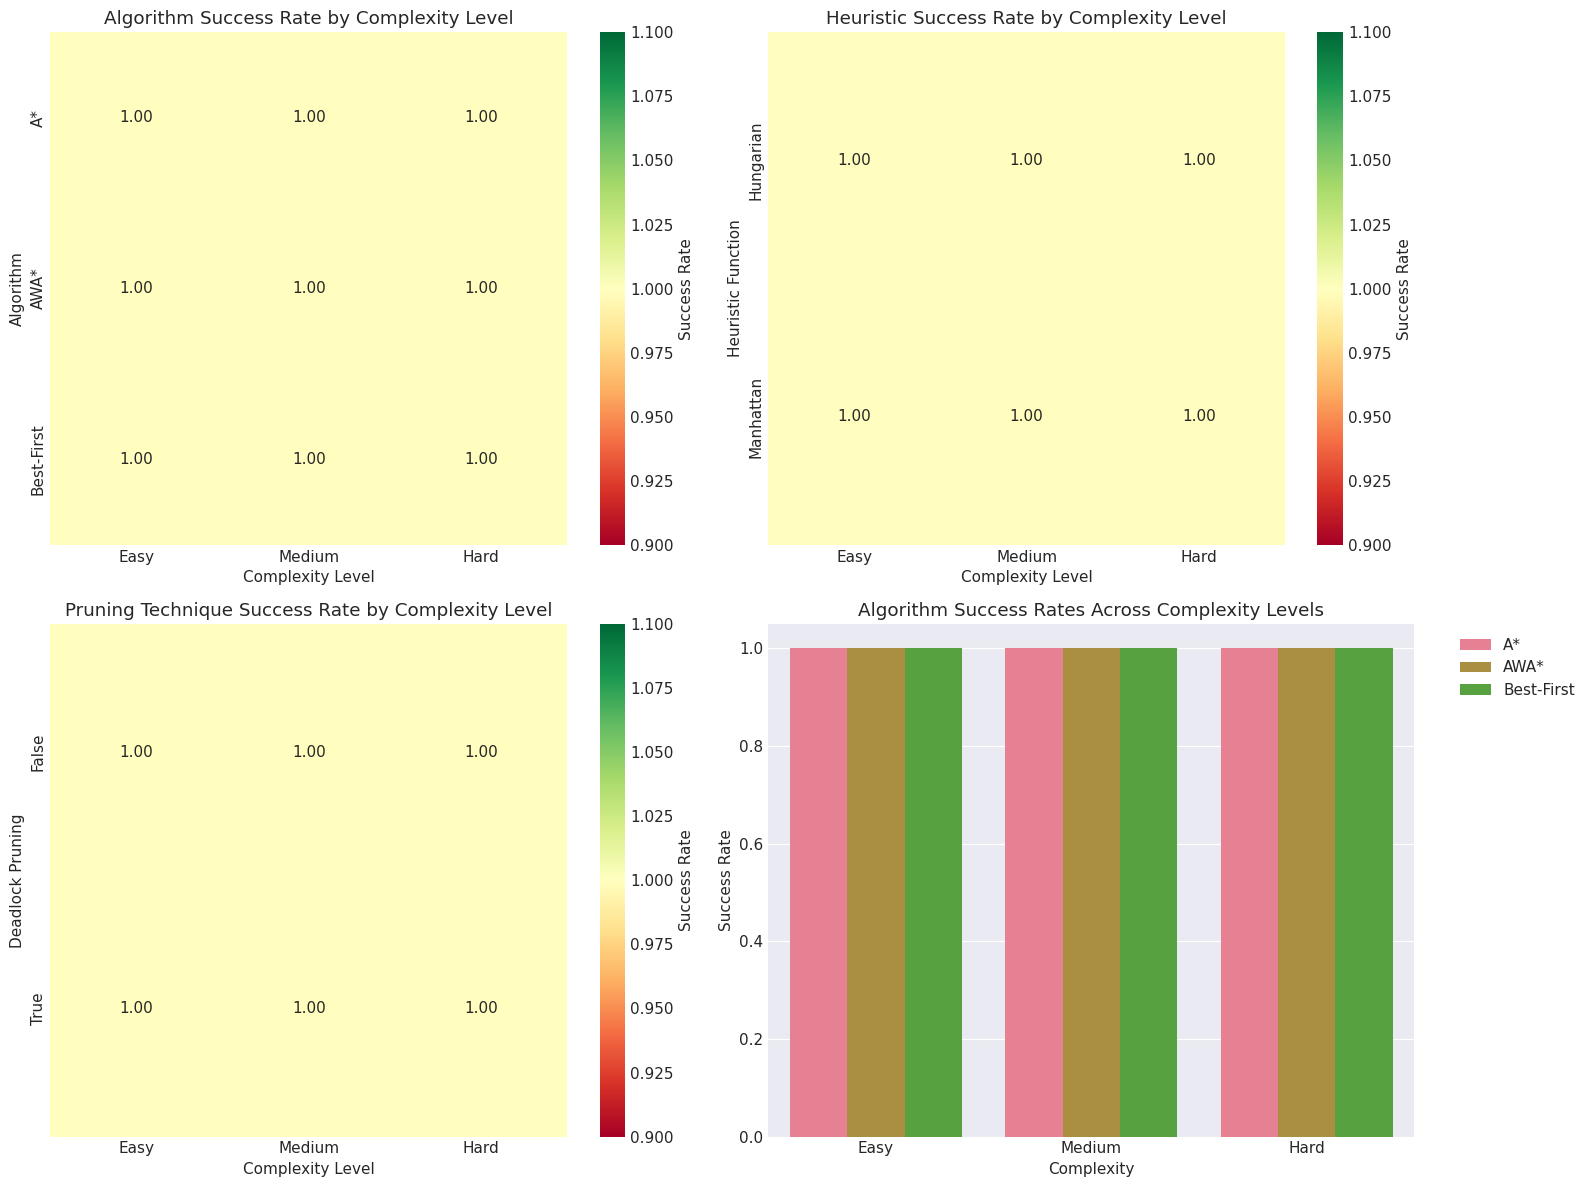

\n============================================================
KEY INSIGHTS: SUCCESS RATE ANALYSIS
\n1. ALGORITHM RELIABILITY BY COMPLEXITY:
\nEasy Puzzles:
  A*          : 100.0% (12/12 solved)
  AWA*        : 100.0% (12/12 solved)
  Best-First  : 100.0% (12/12 solved)
\nMedium Puzzles:
  A*          : 100.0% (12/12 solved)
  AWA*        : 100.0% (12/12 solved)
  Best-First  : 100.0% (12/12 solved)
\nHard Puzzles:
  A*          : 100.0% (12/12 solved)
  AWA*        : 100.0% (12/12 solved)
  Best-First  : 100.0% (12/12 solved)
\n2. HEURISTIC EFFECTIVENESS BY COMPLEXITY:
\nEasy Puzzles:
  Hungarian   : 100.0% (18/18 solved)
  Manhattan   : 100.0% (18/18 solved)
\nMedium Puzzles:
  Hungarian   : 100.0% (18/18 solved)
  Manhattan   : 100.0% (18/18 solved)
\nHard Puzzles:
  Hungarian   : 100.0% (18/18 solved)
  Manhattan   : 100.0% (18/18 solved)
\n3. PRUNING IMPACT BY COMPLEXITY:
\nEasy Puzzles:
  No Pruning          : 100.0% (18/18 solved)
  With Deadlock Pruning: 100.0% (18/18 solved)
\

In [4]:
# Create success rate analysis
def analyze_success_rates(puzzle_complexity='complexity', complexity_order=['Easy', 'Medium', 'Hard']):
    """Analyze success rates across complexity levels"""

    # Ensure complexity column is categorical with proper ordering
    df_main_ordered = df_main.copy()
    df_main_ordered[puzzle_complexity] = pd.Categorical(
        df_main_ordered[puzzle_complexity], 
        categories=complexity_order, 
        ordered=True
    )
    # Overall success rate by algorithm and complexity
    success_by_algo_complexity = df_main_ordered.groupby(['algorithm_clean', puzzle_complexity])['solved'].agg(['count', 'sum', 'mean']).reset_index()
    success_by_algo_complexity['success_rate'] = success_by_algo_complexity['mean']
    
    # Success rate by heuristic and complexity
    success_by_heur_complexity = df_main_ordered.groupby(['heuristic_clean', puzzle_complexity])['solved'].agg(['count', 'sum', 'mean']).reset_index()
    success_by_heur_complexity['success_rate'] = success_by_heur_complexity['mean']
    
    # Success rate by pruning and complexity
    success_by_pruning_complexity = df_main_ordered.groupby(['pruning_deadlock', puzzle_complexity])['solved'].agg(['count', 'sum', 'mean']).reset_index()
    success_by_pruning_complexity['success_rate'] = success_by_pruning_complexity['mean']
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Algorithm success rates by complexity
    pivot_algo = success_by_algo_complexity.pivot(index='algorithm_clean', columns=puzzle_complexity, values='success_rate')
    # Reorder columns to ensure proper complexity order
    pivot_algo = pivot_algo.reindex(columns=complexity_order)
    sns.heatmap(pivot_algo, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[0,0], 
                cbar_kws={'label': 'Success Rate'})
    axes[0,0].set_title('Algorithm Success Rate by Complexity Level')
    axes[0,0].set_xlabel('Complexity Level')
    axes[0,0].set_ylabel('Algorithm')
    
    # Plot 2: Heuristic success rates by complexity
    pivot_heur = success_by_heur_complexity.pivot(index='heuristic_clean', columns=puzzle_complexity, values='success_rate')
    # Reorder columns to ensure proper complexity order
    pivot_heur = pivot_heur.reindex(columns=complexity_order)
    sns.heatmap(pivot_heur, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[0,1],
                cbar_kws={'label': 'Success Rate'})
    axes[0,1].set_title('Heuristic Success Rate by Complexity Level')
    axes[0,1].set_xlabel('Complexity Level')
    axes[0,1].set_ylabel('Heuristic Function')
    
    # Plot 3: Pruning impact by complexity
    pivot_pruning = success_by_pruning_complexity.pivot(index='pruning_deadlock', columns=puzzle_complexity, values='success_rate')
    # Reorder columns to ensure proper complexity order
    pivot_pruning = pivot_pruning.reindex(columns=complexity_order)
    sns.heatmap(pivot_pruning, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[1,0],
                cbar_kws={'label': 'Success Rate'})
    axes[1,0].set_title('Pruning Technique Success Rate by Complexity Level')
    axes[1,0].set_xlabel('Complexity Level')
    axes[1,0].set_ylabel('Deadlock Pruning')
    
    # Plot 4: Detailed algorithm comparison
    # Bar plot for success rates with proper ordering
    success_data = []
    for (algo, complexity), group in df_main_ordered.groupby(['algorithm_clean', puzzle_complexity]):
        success_rate = group['solved'].mean()
        total_attempts = len(group)
        success_data.append({
            'Algorithm': algo,
            'Complexity': complexity,
            'Success Rate': success_rate,
            'Attempts': total_attempts
        })
    
    success_df = pd.DataFrame(success_data)
    # Ensure complexity is categorical with proper order
    success_df['Complexity'] = pd.Categorical(
        success_df['Complexity'], 
        categories=complexity_order, 
        ordered=True
    )
    
    sns.barplot(data=success_df, x='Complexity', y='Success Rate', hue='Algorithm', ax=axes[1,1], order=complexity_order)
    axes[1,1].set_title('Algorithm Success Rates Across Complexity Levels')
    axes[1,1].set_ylim(0, 1.05)
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('success_rate_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return success_by_algo_complexity, success_by_heur_complexity, success_by_pruning_complexity

success_algo, success_heur, success_pruning = analyze_success_rates()

# Print key insights
print("\\n" + "="*60)
print("KEY INSIGHTS: SUCCESS RATE ANALYSIS")
print("="*60)
# sort df main by complexity to be in the order of easy, medium, hard
complexity_order = ['Easy', 'Medium', 'Hard']
print("\\n1. ALGORITHM RELIABILITY BY COMPLEXITY:")
for complexity in complexity_order:
    print(f"\\n{complexity} Puzzles:")
    if complexity in success_algo['complexity'].values:
        complexity_data = success_algo[success_algo['complexity'] == complexity]
        for _, row in complexity_data.iterrows():
            print(f"  {row['algorithm_clean']:12}: {row['success_rate']:5.1%} ({row['sum']}/{row['count']} solved)")

print("\\n2. HEURISTIC EFFECTIVENESS BY COMPLEXITY:")
for complexity in complexity_order:
    print(f"\\n{complexity} Puzzles:")
    if complexity in success_heur['complexity'].values:
        complexity_data = success_heur[success_heur['complexity'] == complexity]
        for _, row in complexity_data.iterrows():
            print(f"  {row['heuristic_clean']:12}: {row['success_rate']:5.1%} ({row['sum']}/{row['count']} solved)")

print("\\n3. PRUNING IMPACT BY COMPLEXITY:")
for complexity in complexity_order:
    print(f"\\n{complexity} Puzzles:")
    if complexity in success_pruning['complexity'].values:
        complexity_data = success_pruning[success_pruning['complexity'] == complexity]
        for _, row in complexity_data.iterrows():
            pruning_name = "With Deadlock Pruning" if row['pruning_deadlock'] else "No Pruning"
            print(f"  {pruning_name:20}: {row['success_rate']:5.1%} ({row['sum']}/{row['count']} solved)")


### 2.2 Computational Scaling Analysis
Examining how resource requirements scale with problem complexity


Analyzing computational scaling by: Complexity Level
Categories/Levels: ['Easy', 'Medium', 'Hard']


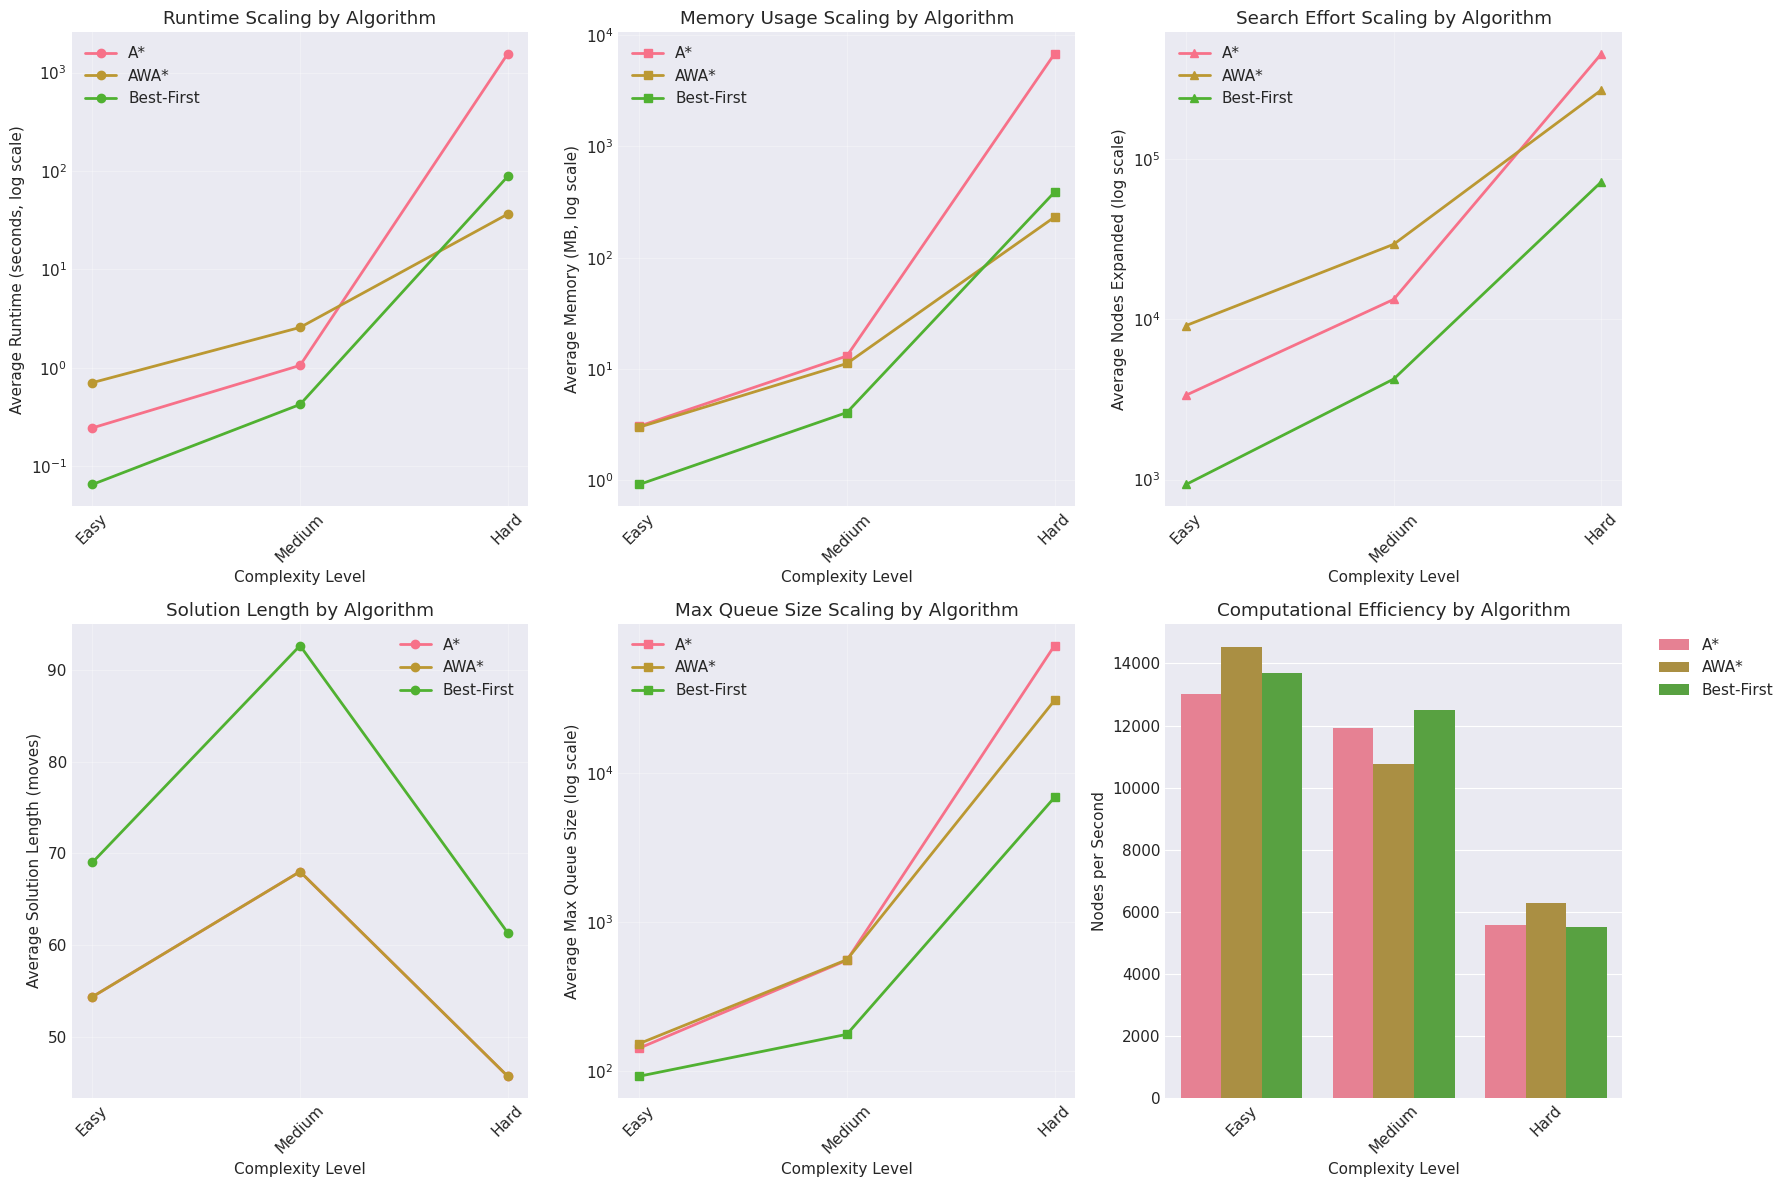

\n============================================================
KEY INSIGHTS: COMPUTATIONAL SCALING (Complexity Level)
\n1. ALGORITHM SCALING FACTORS (Easy → Hard):
\nA*:
  Runtime scaling:    6333.9x
  Memory scaling:     2216.0x
  Search scaling:      134.8x
\nAWA*:
  Runtime scaling:      51.6x
  Memory scaling:       77.2x
  Search scaling:       29.5x
\nBest-First:
  Runtime scaling:    1349.9x
  Memory scaling:      423.1x
  Search scaling:       77.3x
\n2. COMPUTATIONAL EFFICIENCY RANKING:
  1. Best-First  :   10,565 nodes/second
  2. AWA*        :   10,527 nodes/second
  3. A*          :   10,168 nodes/second
\n3. OPTIMALITY AND MEMORY TRADE-OFFS:
\nA*:
  Avg Runtime:        516.21 seconds
  Avg Memory:        2264.92 MB
  Avg Max Queue:      24,102 states
  Avg Solution Len:     56.0 moves
  Avg Nodes:         156,484
\nAWA*:
  Avg Runtime:         13.22 seconds
  Avg Memory:          81.84 MB
  Avg Max Queue:      10,476 states
  Avg Solution Len:     56.0 moves
  Avg Nodes:  

In [5]:
def analyze_computational_scaling(complexity_attribute='complexity'):
    """Analyze how computational requirements scale with complexity
    
    Args:
        complexity_attribute (str): Column name to use for complexity analysis 
                                  (e.g., 'complexity', 'level_number', 'puzzle_name')
    """
    
    # Only analyze solved puzzles for fair comparison
    # df_solved = df_main[df_main['solved'] == True].copy()
    df_solved = df_main.copy()
    if len(df_solved) == 0:
        print("No solved puzzles found for scaling analysis")
        return
    
    # Determine complexity order based on attribute type
    if complexity_attribute == 'complexity':
        complexity_order = ['Easy', 'Medium', 'Hard']
        attribute_display_name = 'Complexity Level'
    elif complexity_attribute == 'level_number':
        # Extract numeric level numbers and sort them
        df_solved['level_number'] = df_solved['puzzle_name'].str.extract(r'level_(\d+)').astype(int)
        complexity_order = sorted(df_solved['level_number'].unique())
        attribute_display_name = 'Level Number'
    else:
        # For other attributes, get unique values and sort them
        complexity_order = sorted(df_solved[complexity_attribute].unique())
        attribute_display_name = complexity_attribute.replace('_', ' ').title()
    
    print(f"Analyzing computational scaling by: {attribute_display_name}")
    print(f"Categories/Levels: {complexity_order}")
    
    # Create scaling analysis plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Determine if we should use categorical or numeric X-axis
    if complexity_attribute == 'level_number':
        # Use actual level numbers on X-axis for numerical progression
        x_values = complexity_order
        use_categorical = False
    else:
        # Use categorical positions for complexity or other attributes
        x_values = range(len(complexity_order))
        use_categorical = True
    
    # Plot 1: Runtime scaling by algorithm
    for algo in df_solved['algorithm_clean'].unique():
        algo_data = df_solved[df_solved['algorithm_clean'] == algo]
        avg_runtime = algo_data.groupby(complexity_attribute)['runtime_seconds'].mean()
        y_values = [avg_runtime.get(c, np.nan) for c in complexity_order]
        axes[0,0].plot(x_values, y_values, 
                      marker='o', linewidth=2, label=algo)
    
    axes[0,0].set_yscale('log')
    axes[0,0].set_title(f'Runtime Scaling by Algorithm')
    axes[0,0].set_xlabel(attribute_display_name)
    axes[0,0].set_ylabel('Average Runtime (seconds, log scale)')
    if use_categorical:
        axes[0,0].set_xticks(x_values)
        axes[0,0].set_xticklabels(complexity_order, rotation=45 if len(str(complexity_order[0])) > 3 else 0)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Memory scaling by algorithm
    for algo in df_solved['algorithm_clean'].unique():
        algo_data = df_solved[df_solved['algorithm_clean'] == algo]
        avg_memory = algo_data.groupby(complexity_attribute)['memory_peak_mb'].mean()
        y_values = [avg_memory.get(c, np.nan) for c in complexity_order]
        axes[0,1].plot(x_values, y_values,
                      marker='s', linewidth=2, label=algo)
    
    axes[0,1].set_yscale('log')
    axes[0,1].set_title(f'Memory Usage Scaling by Algorithm')
    axes[0,1].set_xlabel(attribute_display_name)
    axes[0,1].set_ylabel('Average Memory (MB, log scale)')
    if use_categorical:
        axes[0,1].set_xticks(x_values)
        axes[0,1].set_xticklabels(complexity_order, rotation=45 if len(str(complexity_order[0])) > 3 else 0)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Nodes expanded scaling by algorithm
    for algo in df_solved['algorithm_clean'].unique():
        algo_data = df_solved[df_solved['algorithm_clean'] == algo]
        avg_nodes = algo_data.groupby(complexity_attribute)['nodes_expanded'].mean()
        y_values = [avg_nodes.get(c, np.nan) for c in complexity_order]
        axes[0,2].plot(x_values, y_values,
                      marker='^', linewidth=2, label=algo)
    
    axes[0,2].set_yscale('log')
    axes[0,2].set_title(f'Search Effort Scaling by Algorithm')
    axes[0,2].set_xlabel(attribute_display_name)
    axes[0,2].set_ylabel('Average Nodes Expanded (log scale)')
    if use_categorical:
        axes[0,2].set_xticks(x_values)
        axes[0,2].set_xticklabels(complexity_order, rotation=45 if len(str(complexity_order[0])) > 3 else 0)
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Solution optimality by algorithm (only solved puzzles)
    df_solved_only = df_solved[df_solved['solved'] == True].copy()
    if len(df_solved_only) > 0:
        for algo in df_solved_only['algorithm_clean'].unique():
            algo_data = df_solved_only[df_solved_only['algorithm_clean'] == algo]
            avg_solution_length = algo_data.groupby(complexity_attribute)['solution_length'].mean()
            y_values = [avg_solution_length.get(c, np.nan) for c in complexity_order]
            axes[1,0].plot(x_values, y_values,
                          marker='o', linewidth=2, label=algo)
        
        axes[1,0].set_title(f'Solution Length by Algorithm')
        axes[1,0].set_xlabel(attribute_display_name)
        axes[1,0].set_ylabel('Average Solution Length (moves)')
        if use_categorical:
            axes[1,0].set_xticks(x_values)
            axes[1,0].set_xticklabels(complexity_order, rotation=45 if len(str(complexity_order[0])) > 3 else 0)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].text(0.5, 0.5, 'No solved puzzles available\nfor optimality analysis', 
                      ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title(f'Solution Length by Algorithm')
    
    # Plot 5: Max queue size scaling by algorithm
    for algo in df_solved['algorithm_clean'].unique():
        algo_data = df_solved[df_solved['algorithm_clean'] == algo]
        avg_max_queue = algo_data.groupby(complexity_attribute)['max_queue_size'].mean()
        y_values = [avg_max_queue.get(c, np.nan) for c in complexity_order]
        axes[1,1].plot(x_values, y_values,
                      marker='s', linewidth=2, label=algo)
    
    axes[1,1].set_yscale('log')
    axes[1,1].set_title(f'Max Queue Size Scaling by Algorithm')
    axes[1,1].set_xlabel(attribute_display_name)
    axes[1,1].set_ylabel('Average Max Queue Size (log scale)')
    if use_categorical:
        axes[1,1].set_xticks(x_values)
        axes[1,1].set_xticklabels(complexity_order, rotation=45 if len(str(complexity_order[0])) > 3 else 0)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # Plot 6: Efficiency metric - nodes per second
    df_solved['nodes_per_second'] = df_solved['nodes_expanded'] / df_solved['runtime_seconds']
    
    efficiency_data = []
    for (algo, complexity), group in df_solved.groupby(['algorithm_clean', complexity_attribute]):
        avg_efficiency = group['nodes_per_second'].mean()
        efficiency_data.append({
            'Algorithm': algo,
            attribute_display_name: complexity,
            'Nodes per Second': avg_efficiency
        })
    
    efficiency_df = pd.DataFrame(efficiency_data)
    
    # Handle ordering for the bar plot
    if complexity_attribute == 'complexity':
        order = complexity_order
    else:
        order = complexity_order
    
    sns.barplot(data=efficiency_df, x=attribute_display_name, y='Nodes per Second', hue='Algorithm', 
                ax=axes[1,2], order=order)
    axes[1,2].set_title(f'Computational Efficiency by Algorithm')
    axes[1,2].set_ylabel('Nodes per Second')
    axes[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if len(str(complexity_order[0])) > 3:
        axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate scaling factors (from first to last in complexity order)
    scaling_stats = {}
    first_level = complexity_order[0]
    last_level = complexity_order[-1]
    
    for algo in df_solved['algorithm_clean'].unique():
        algo_data = df_solved[df_solved['algorithm_clean'] == algo]
        
        # Calculate scaling factors from first to last complexity level
        first_runtime = algo_data[algo_data[complexity_attribute] == first_level]['runtime_seconds'].mean()
        last_runtime = algo_data[algo_data[complexity_attribute] == last_level]['runtime_seconds'].mean()
        
        first_memory = algo_data[algo_data[complexity_attribute] == first_level]['memory_peak_mb'].mean()
        last_memory = algo_data[algo_data[complexity_attribute] == last_level]['memory_peak_mb'].mean()
        
        first_nodes = algo_data[algo_data[complexity_attribute] == first_level]['nodes_expanded'].mean()
        last_nodes = algo_data[algo_data[complexity_attribute] == last_level]['nodes_expanded'].mean()
        
        scaling_stats[algo] = {
            'runtime_scaling': last_runtime / first_runtime if first_runtime > 0 else np.inf,
            'memory_scaling': last_memory / first_memory if first_memory > 0 else np.inf,
            'nodes_scaling': last_nodes / first_nodes if first_nodes > 0 else np.inf,
            'first_level': first_level,
            'last_level': last_level
        }
    
    return scaling_stats, efficiency_df, complexity_order, attribute_display_name

# Default analysis by complexity levels (Easy, Medium, Hard)
scaling_stats, efficiency_df, complexity_order, attribute_display_name = analyze_computational_scaling()

# Print scaling insights
print("\\n" + "="*60)
print(f"KEY INSIGHTS: COMPUTATIONAL SCALING ({attribute_display_name})")
print("="*60)

print(f"\\n1. ALGORITHM SCALING FACTORS ({scaling_stats[list(scaling_stats.keys())[0]]['first_level']} → {scaling_stats[list(scaling_stats.keys())[0]]['last_level']}):")
for algo, stats in scaling_stats.items():
    print(f"\\n{algo}:")
    print(f"  Runtime scaling:  {stats['runtime_scaling']:8.1f}x")
    print(f"  Memory scaling:   {stats['memory_scaling']:8.1f}x") 
    print(f"  Search scaling:   {stats['nodes_scaling']:8.1f}x")

print("\\n2. COMPUTATIONAL EFFICIENCY RANKING:")
if len(efficiency_df) > 0:
    avg_efficiency = efficiency_df.groupby('Algorithm')['Nodes per Second'].mean().sort_values(ascending=False)
    for i, (algo, efficiency) in enumerate(avg_efficiency.items(), 1):
        print(f"  {i}. {algo:12}: {efficiency:8,.0f} nodes/second")

print("\\n3. OPTIMALITY AND MEMORY TRADE-OFFS:")
df_solved_summary = df_main[df_main['solved'] == True].groupby('algorithm_clean').agg({
    'runtime_seconds': 'mean',
    'memory_peak_mb': 'mean',
    'nodes_expanded': 'mean',
    'solution_length': 'mean',
    'max_queue_size': 'mean'
}).round(2)

for algo in df_solved_summary.index:
    row = df_solved_summary.loc[algo]
    print(f"\\n{algo}:")
    print(f"  Avg Runtime:      {row['runtime_seconds']:8.2f} seconds")
    print(f"  Avg Memory:       {row['memory_peak_mb']:8.2f} MB")
    print(f"  Avg Max Queue:    {row['max_queue_size']:8,.0f} states")
    print(f"  Avg Solution Len: {row['solution_length']:8.1f} moves")
    print(f"  Avg Nodes:        {row['nodes_expanded']:8,.0f}")

print("\\n\\n" + "="*60)
print("EXAMPLE: Run analysis by level number instead:")
print("scaling_stats_by_level, efficiency_by_level, _, _ = analyze_computational_scaling('level_number')")
print("="*60)

\n================================================================================
ALTERNATIVE ANALYSIS: BY INDIVIDUAL LEVEL NUMBERS
Analyzing computational scaling by: Level Number
Categories/Levels: [3, 7, 9, 12, 14, 17, 20, 23, 26]


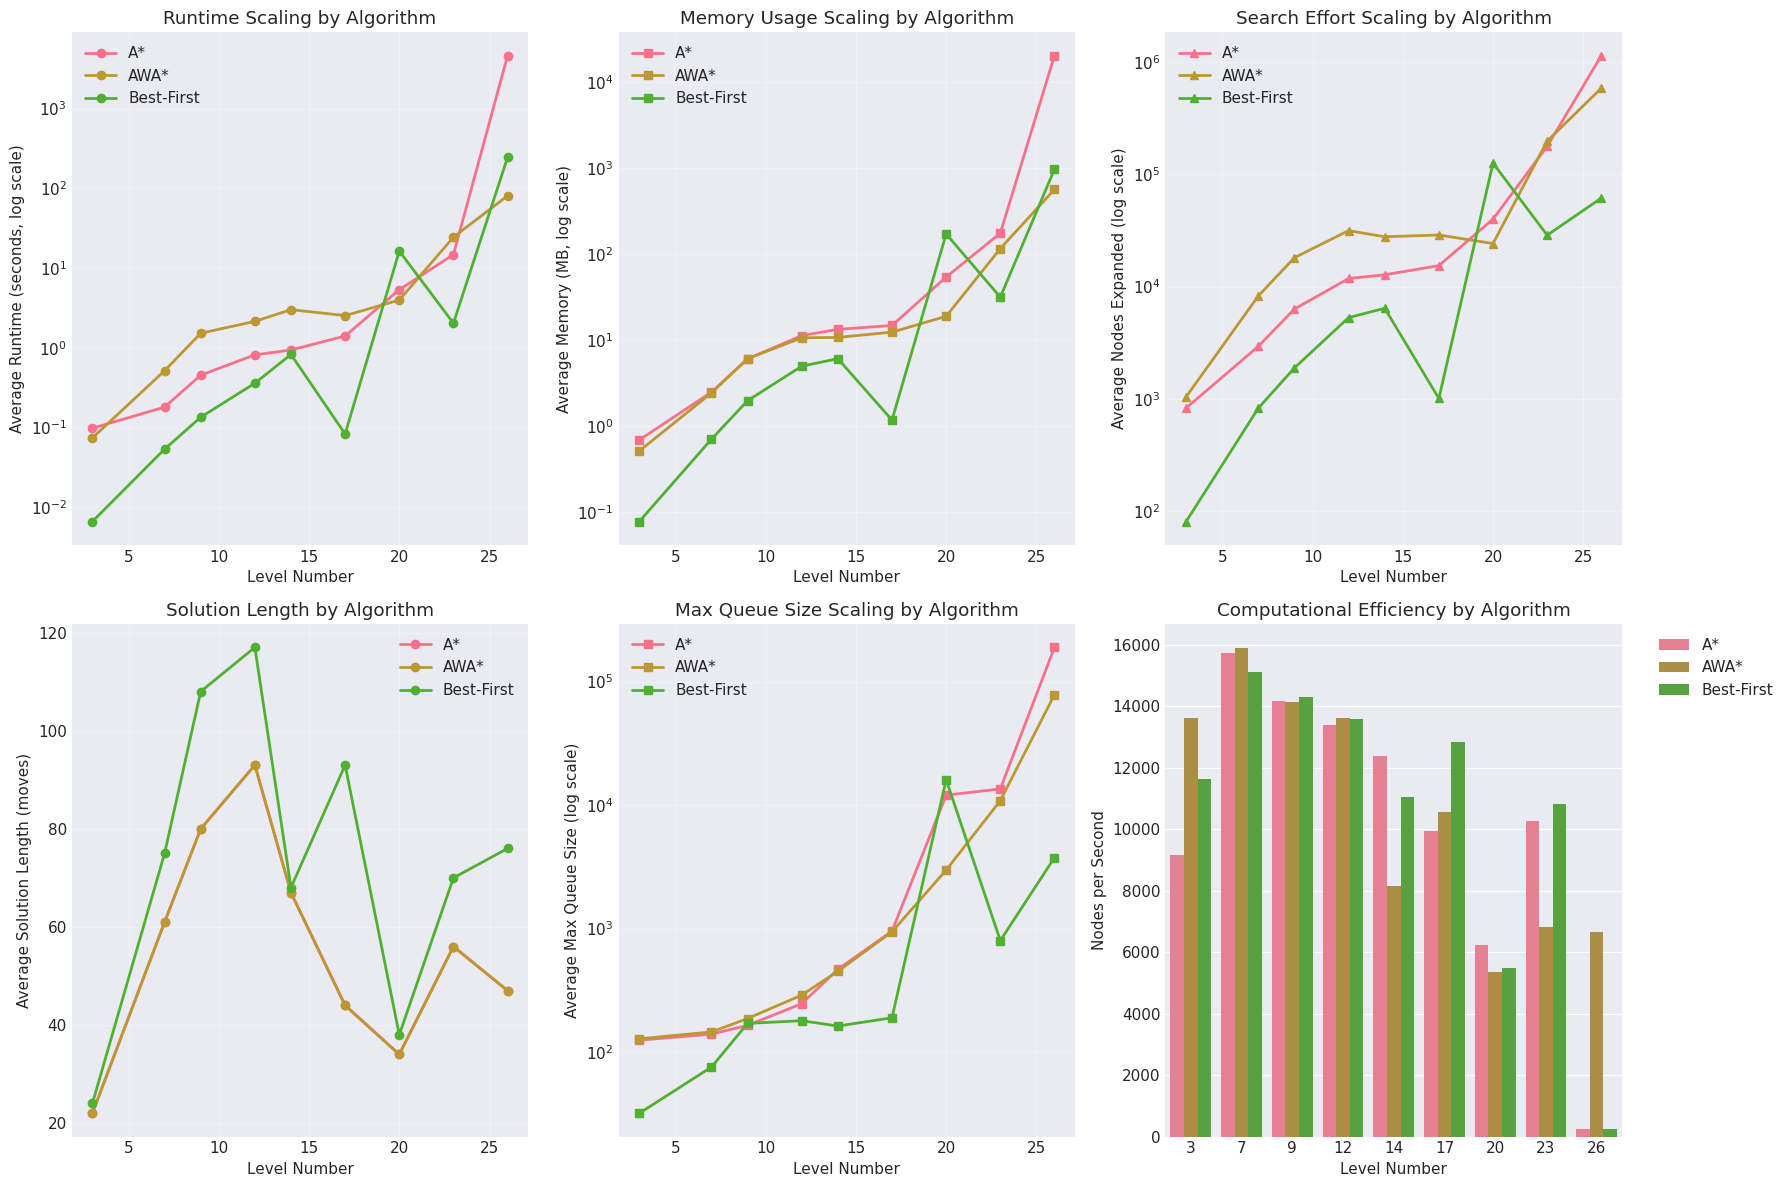

\n============================================================
KEY INSIGHTS: COMPUTATIONAL SCALING (Level Number)
\n1. ALGORITHM SCALING FACTORS (3 → 26):
\nA*:
  Runtime scaling:   47139.6x
  Memory scaling:    29235.5x
  Search scaling:     1377.7x
\nAWA*:
  Runtime scaling:    1089.3x
  Memory scaling:     1093.5x
  Search scaling:      561.0x
\nBest-First:
  Runtime scaling:   36966.0x
  Memory scaling:    12392.5x
  Search scaling:      761.2x
\nLevel progression analyzed: [3, 7, 9, 12, 14, 17, 20, 23, 26]
This shows algorithm performance scaling across 9 individual puzzle levels.


In [6]:
# Example: Analyze computational scaling by level number instead of complexity categories
print("\\n" + "="*80)
print("ALTERNATIVE ANALYSIS: BY INDIVIDUAL LEVEL NUMBERS")
print("="*80)

# Run analysis by level number
scaling_stats_by_level, efficiency_by_level, level_order, level_display_name = analyze_computational_scaling('level_number')

# Print level-specific insights
print("\\n" + "="*60)
print(f"KEY INSIGHTS: COMPUTATIONAL SCALING ({level_display_name})")
print("="*60)

print(f"\\n1. ALGORITHM SCALING FACTORS ({scaling_stats_by_level[list(scaling_stats_by_level.keys())[0]]['first_level']} → {scaling_stats_by_level[list(scaling_stats_by_level.keys())[0]]['last_level']}):")
for algo, stats in scaling_stats_by_level.items():
    print(f"\\n{algo}:")
    print(f"  Runtime scaling:  {stats['runtime_scaling']:8.1f}x")
    print(f"  Memory scaling:   {stats['memory_scaling']:8.1f}x") 
    print(f"  Search scaling:   {stats['nodes_scaling']:8.1f}x")

print(f"\\nLevel progression analyzed: {level_order}")
print(f"This shows algorithm performance scaling across {len(level_order)} individual puzzle levels.")


### 2.3 Algorithm Performance Summary Tables
Comprehensive performance comparison using Hungarian heuristic with deadlock detection


\n================================================================================
ALGORITHM PERFORMANCE SUMMARY: BY COMPLEXITY LEVEL
Creating performance summary tables by: Complexity Level
Configuration: Hungarian Heuristic + Deadlock Detection
Categories/Levels: ['Easy', 'Medium', 'Hard']
Solved puzzles analyzed: 27


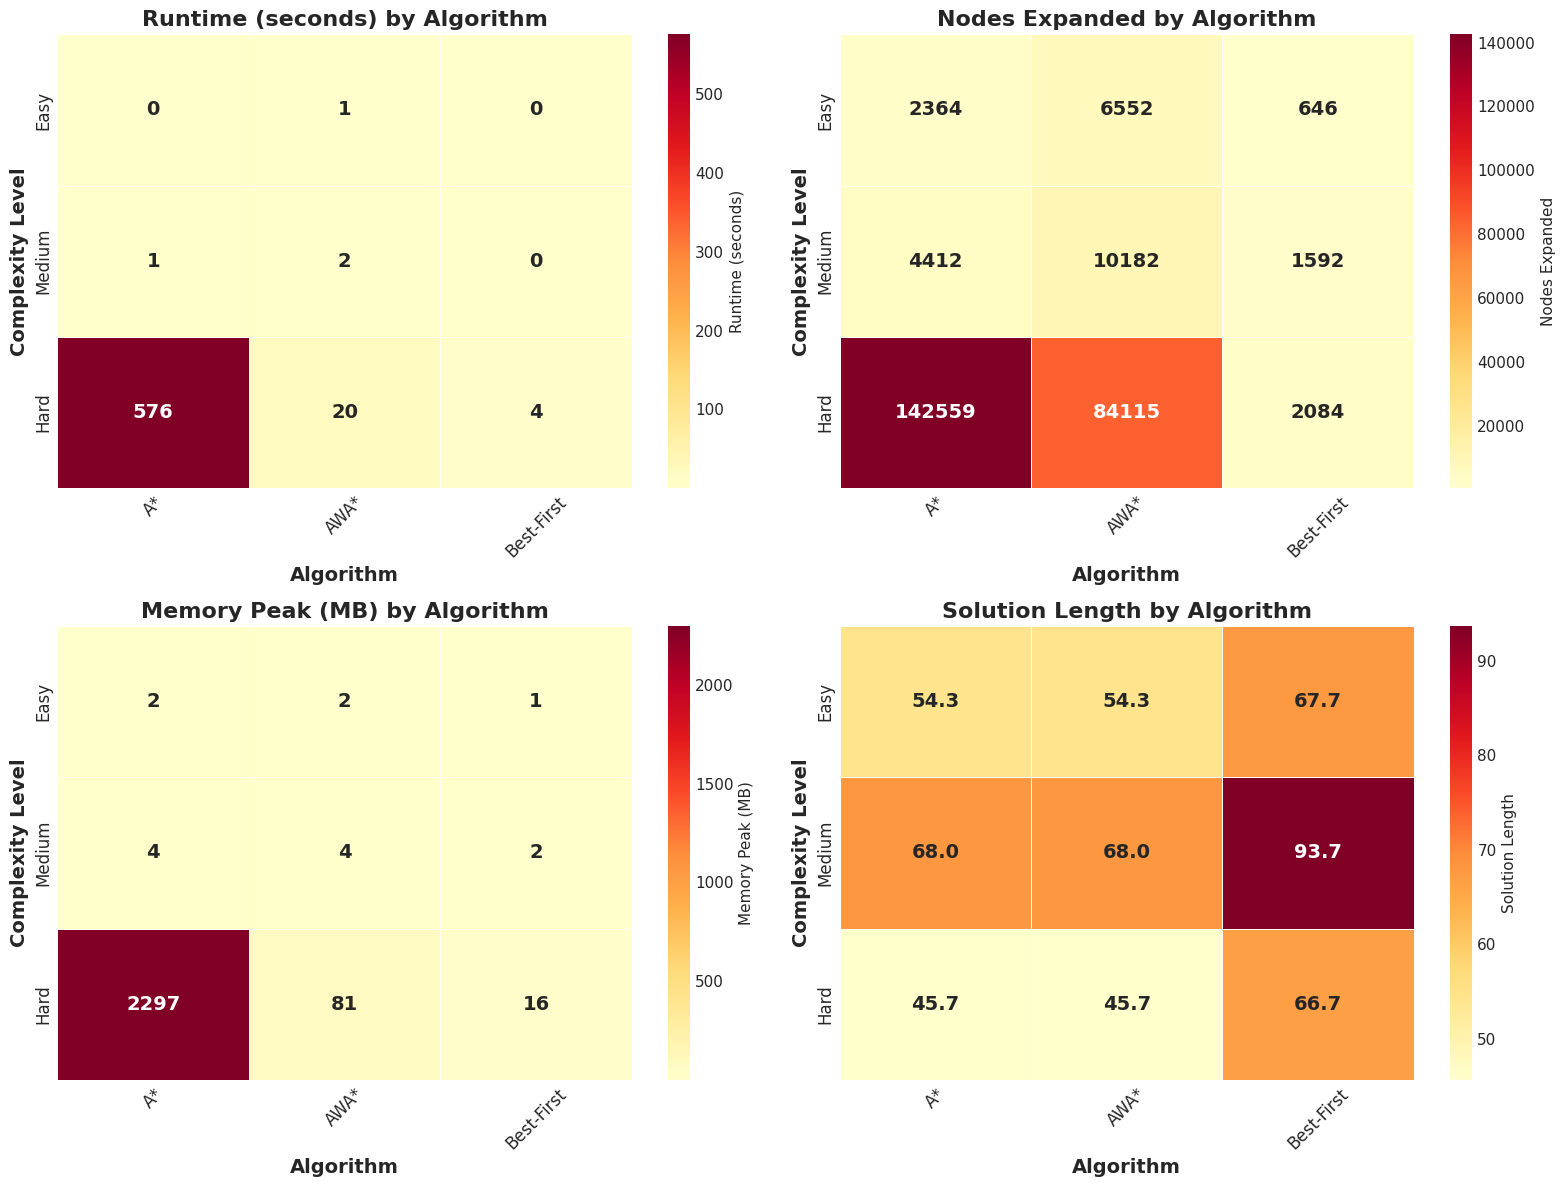

\n================================================================================
DETAILED PERFORMANCE SUMMARY TABLES
\nRuntime (seconds) Summary:
--------------------------
algorithm_clean      A*   AWA*  Best-First
complexity                                
Easy               0.21   0.65        0.06
Medium             0.55   1.73        0.20
Hard             576.00  20.34        4.15
\nNodes Expanded Summary:
-----------------------
algorithm_clean      A*   AWA*  Best-First
complexity                                
Easy               2364   6552         646
Medium             4412  10182        1592
Hard             142559  84115        2084
\nMemory Peak (MB) Summary:
-------------------------
algorithm_clean      A*  AWA*  Best-First
complexity                               
Easy                2.3   2.3         0.7
Medium              4.2   3.7         1.6
Hard             2297.2  80.9        15.9
\nSolution Length Summary:
------------------------
algorithm_clean    A*  AWA*  

In [19]:
def create_performance_summary_tables(complexity_attribute='complexity'):
    """Create summary tables showing algorithm performance with Hungarian heuristic + deadlock detection
    
    Args:
        complexity_attribute (str): Column name to use for complexity analysis 
                                  (e.g., 'complexity', 'level_number')
    """
    
    # Filter data for Hungarian heuristic with deadlock detection
    filtered_data = df_main[
        (df_main['heuristic_clean'] == 'Hungarian') & 
        (df_main['pruning_deadlock'] == True) &
        (df_main['solved'] == True)  # Only solved puzzles for fair comparison
    ].copy()
    
    if len(filtered_data) == 0:
        print("No data available for Hungarian heuristic with deadlock detection")
        return
    
    # Determine complexity order based on attribute type
    if complexity_attribute == 'complexity':
        complexity_order = ['Easy', 'Medium', 'Hard']
        attribute_display_name = 'Complexity Level'
    elif complexity_attribute == 'level_number':
        # Extract numeric level numbers and sort them
        filtered_data['level_number'] = filtered_data['puzzle_name'].str.extract(r'level_(\d+)').astype(int)
        complexity_order = sorted(filtered_data['level_number'].unique())
        attribute_display_name = 'Level Number'
    else:
        # For other attributes, get unique values and sort them
        complexity_order = sorted(filtered_data[complexity_attribute].unique())
        attribute_display_name = complexity_attribute.replace('_', ' ').title()
    
    print(f"Creating performance summary tables by: {attribute_display_name}")
    print(f"Configuration: Hungarian Heuristic + Deadlock Detection")
    print(f"Categories/Levels: {complexity_order}")
    print(f"Solved puzzles analyzed: {len(filtered_data)}")
    
    # Define performance metrics to analyze
    metrics = {
        'Runtime (seconds)': 'runtime_seconds',
        'Nodes Expanded': 'nodes_expanded', 
        'Memory Peak (MB)': 'memory_peak_mb',
        'Solution Length': 'solution_length'
    }
    
    # Create performance summary tables
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    tables_data = {}
    
    for idx, (metric_name, metric_column) in enumerate(metrics.items()):
        # Create pivot table: rows=complexity, columns=algorithms, values=metric
        pivot_table = filtered_data.pivot_table(
            index=complexity_attribute,
            columns='algorithm_clean', 
            values=metric_column,
            aggfunc='mean'
        ).reindex(complexity_order)
        
        # Store for return
        tables_data[metric_name] = pivot_table
        
        if metric_column in ['runtime_seconds', 'nodes_expanded', 'memory_peak_mb']:
        # integers are usually fine here
            annot_table = pivot_table.applymap(lambda x: '' if np.isnan(x) else f'{x:.0f}')
        else:  # solution length – keep one decimal place
            annot_table = pivot_table.applymap(lambda x: '' if np.isnan(x) else f'{x:.1f}')

        sns.heatmap(
            data=pivot_table,
            annot=annot_table,
            fmt='',
            cmap='YlOrRd',
            ax=axes[idx],
            cbar_kws={'label': metric_name},
            # Add these parameters:
            annot_kws={'size': 14, 'weight': 'bold'},  # Bigger text inside squares
            square=False,  # Allow non-square cells
            linewidths=0.5,  # Add thin lines between cells
            linecolor='white'
        )


        # Increase title and label font sizes
        axes[idx].set_title(f'{metric_name} by Algorithm', fontsize=16, fontweight='bold')  # Increased from 14
        axes[idx].set_xlabel('Algorithm', fontsize=14, fontweight='bold')  # Added fontsize
        axes[idx].set_ylabel(attribute_display_name, fontsize=14, fontweight='bold')  # Added fontsize

        # Make axis tick labels bigger
        axes[idx].tick_params(axis='x', rotation=45, labelsize=12)  # Added labelsize
        axes[idx].tick_params(axis='y', labelsize=12)  # Added labelsize
            
    plt.tight_layout()
    plt.savefig('algorithm_performance_summary_tables.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed tables
    print("\\n" + "="*80)
    print("DETAILED PERFORMANCE SUMMARY TABLES")
    print("="*80)
    
    for metric_name, table in tables_data.items():
        print(f"\\n{metric_name} Summary:")
        print("-" * (len(metric_name) + 9))
        
        # Format the table for better readability
        if metric_name == 'Runtime (seconds)':
            formatted_table = table.round(2)
        elif metric_name == 'Nodes Expanded':
            formatted_table = table.round(0).astype('int64', errors='ignore')
        elif metric_name == 'Memory Peak (MB)':
            formatted_table = table.round(1)
        else:  # Solution Length
            formatted_table = table.round(1)
        
        print(formatted_table.to_string())

    return tables_data

# Create summary tables by complexity
print("\\n" + "="*80)
print("ALGORITHM PERFORMANCE SUMMARY: BY COMPLEXITY LEVEL")
print("="*80)
tables_by_complexity = create_performance_summary_tables('complexity')


Creating performance summary tables by: Level Number
Configuration: Hungarian Heuristic + Deadlock Detection
Categories/Levels: [3, 7, 9, 12, 14, 17, 20, 23, 26]
Solved puzzles analyzed: 27


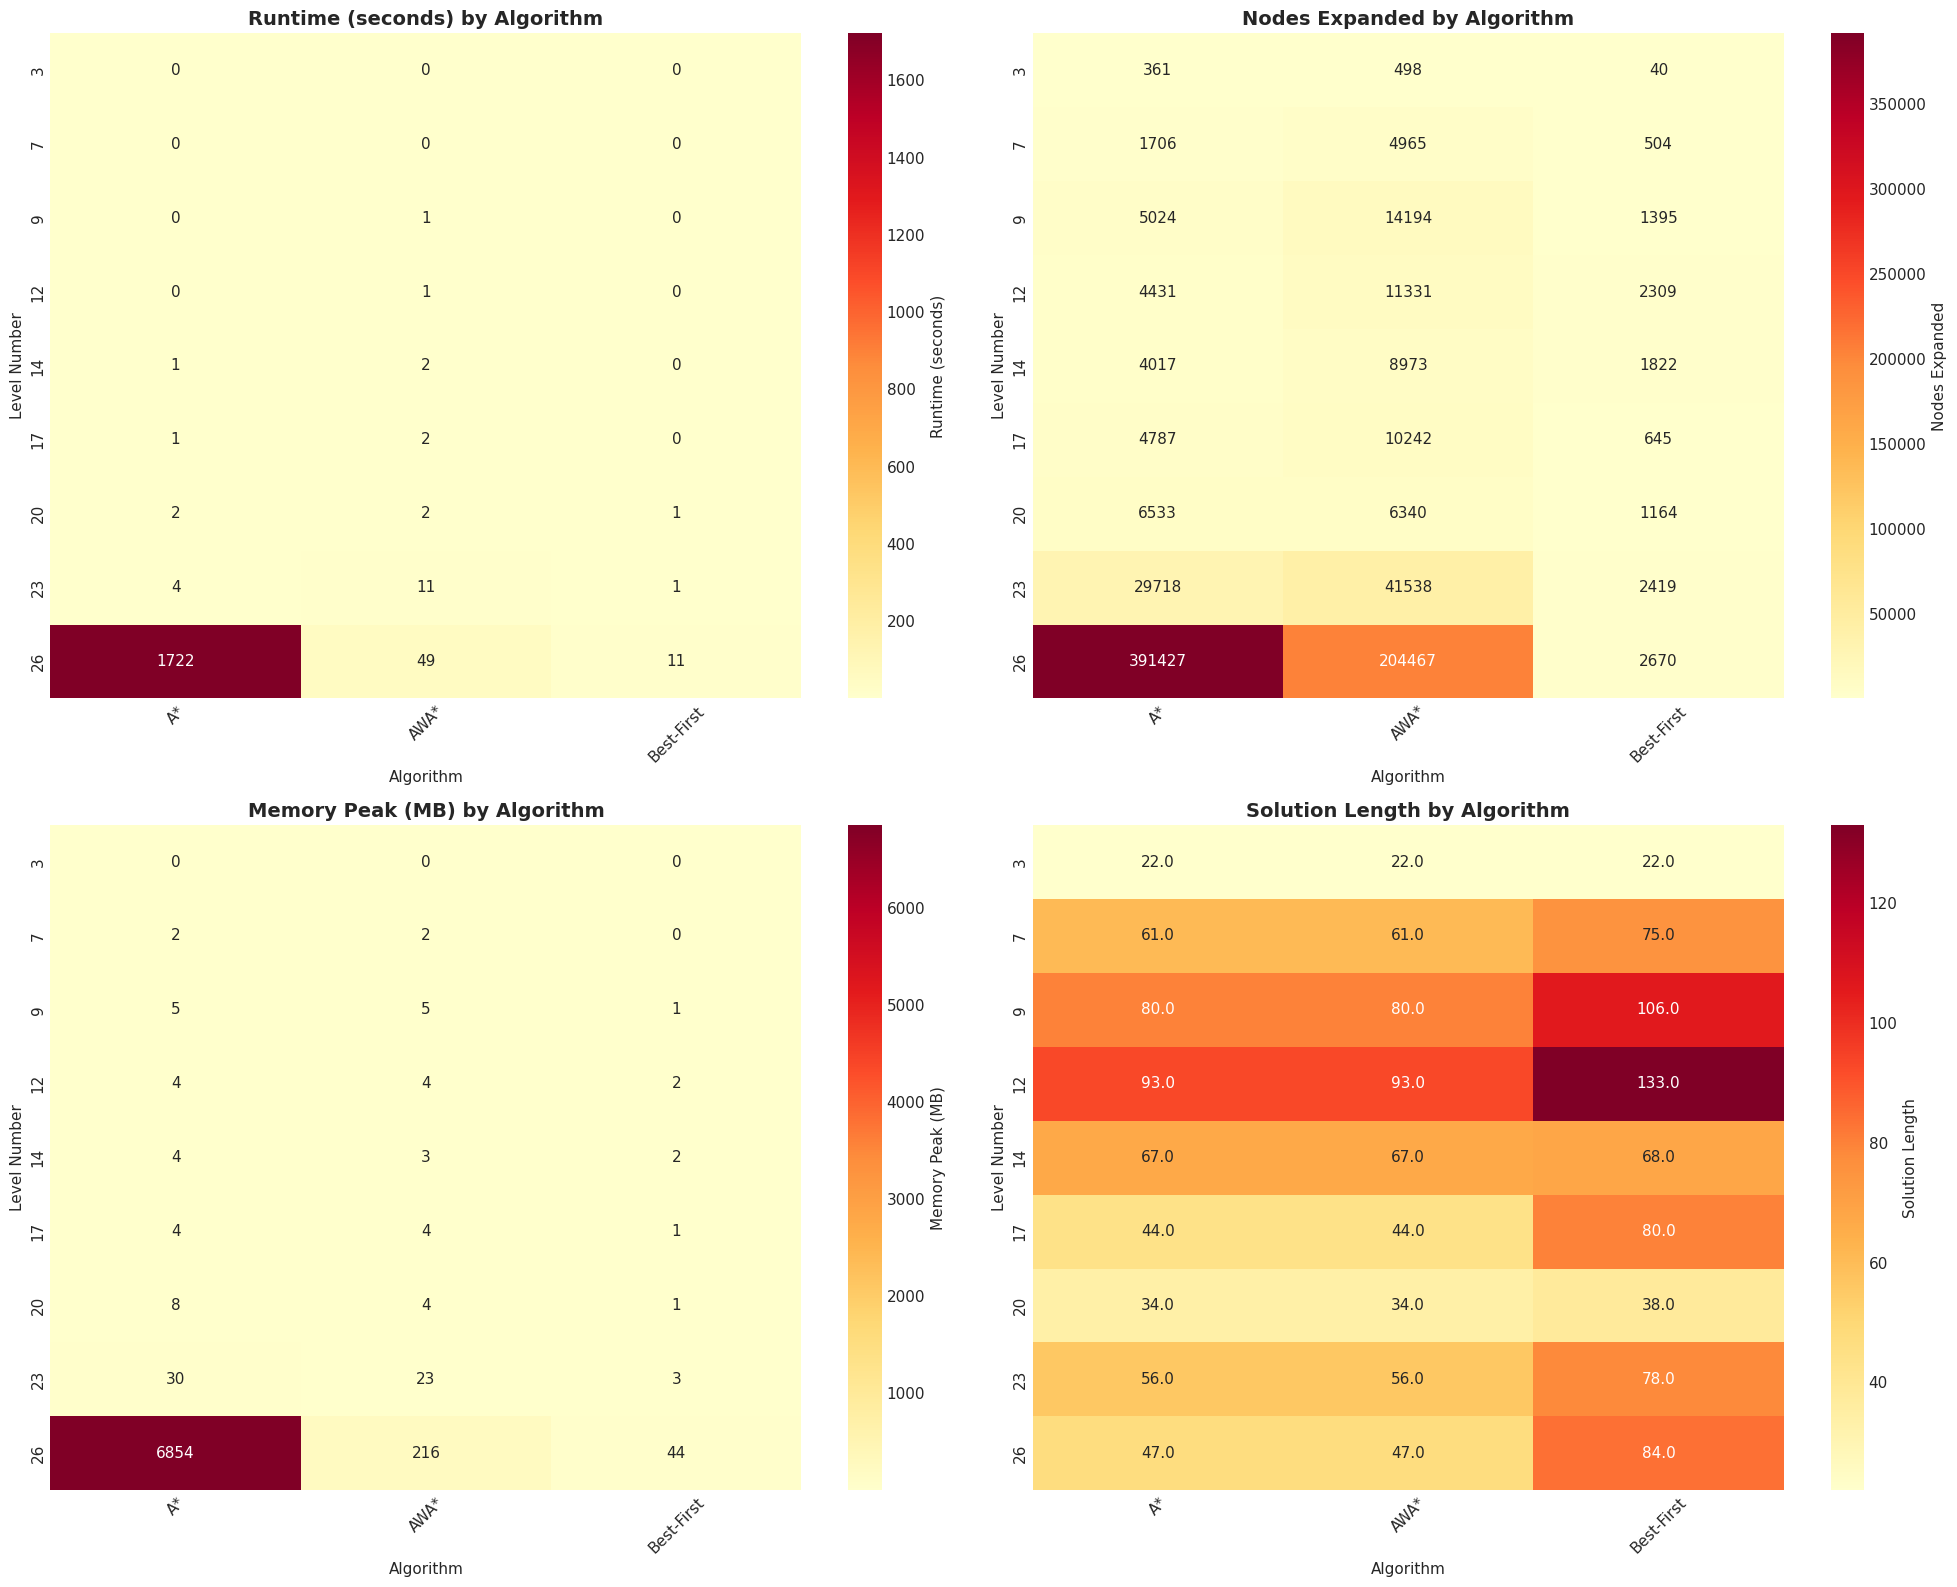

\n================================================================================
DETAILED PERFORMANCE SUMMARY TABLES
\nRuntime (seconds) Summary:
--------------------------
algorithm_clean       A*   AWA*  Best-First
level_number                               
3                   0.04   0.06        0.01
7                   0.14   0.46        0.04
9                   0.44   1.42        0.12
12                  0.45   1.30        0.25
14                  0.54   2.31        0.27
17                  0.66   1.59        0.09
20                  1.57   1.68        0.61
23                  4.32  10.76        0.68
26               1722.10  48.58       11.16
\nNodes Expanded Summary:
-----------------------
algorithm_clean      A*    AWA*  Best-First
level_number                               
3                   361     498          40
7                  1706    4965         504
9                  5024   14194        1395
12                 4431   11331        2309
14                 4017    

In [8]:
tables_by_complexity = create_performance_summary_tables('level_number')


## In-depth Analysis of Anytime Weighted A* (AWA*)


In [9]:
# Define a function to calculate the bound for each experimental group
def calculate_bound_for_group(group):
    # Ensure iterations are in order
    group = group.sort_values('iteration_number')
    # Use infinity for unsolved iterations to correctly find the minimum
    sol_len_with_inf = group['solution_length'].where(group['solved'], np.inf)
    # The bound is the cumulative minimum of previous solutions
    cumulative_min = sol_len_with_inf.cummin()
    # Shift by 1 to get the bound *for* the current iteration from *past* iterations
    group['bound_used'] = cumulative_min.shift(1)
    return group

# Apply this function to each group of iterations
# A group is one experiment run (e.g., level 7, Hungarian, with deadlock)
df_awa_iterations = df_awa_iterations.groupby(
    ['level_number', 'heuristic_clean', 'pruning_deadlock'], 
    group_keys=False
).apply(calculate_bound_for_group)

# The first iteration of each group will have a NaN bound; this represents infinity
df_awa_iterations['bound_used'] = df_awa_iterations['bound_used'].fillna(float('inf'))

print("Created 'bound_used' column successfully.")

# Now, let's inspect the step-by-step improvement for a difficult puzzle, like level 50
# We'll filter for a specific, clear configuration (Hungarian heuristic with deadlock pruning)
level_26_awa_iterations = df_awa_iterations[
    (df_awa_iterations['level_number'] == 26) & 
    (df_awa_iterations['heuristic_clean'] == 'Hungarian') & 
    (df_awa_iterations['pruning_deadlock'] == True)
].copy()

print("\nAWA* Iteration-by-Iteration Performance for Level 26 (Hungarian + Pruning):")
# Using only a subset of columns for cleaner output
print(level_26_awa_iterations[[
    'iteration_number', 'weight', 'solved', 'solution_length', 
    'nodes_expanded', 'runtime_seconds', 'bound_used'
]].to_string())

Created 'bound_used' column successfully.

AWA* Iteration-by-Iteration Performance for Level 26 (Hungarian + Pruning):
    iteration_number weight  solved  solution_length  nodes_expanded  runtime_seconds  bound_used
96                 1   4.00    True               56            5027         0.964252         inf
97                 2   2.40    True               49           27923         6.319463        56.0
98                 3   1.44    True               47          171517        41.298477        49.0


In [10]:
def get_solution_milestones(group):
    # Filter for solved iterations and sort by iteration number to find milestones
    solved_group = group[group['solved']].sort_values('iteration_number')
    if solved_group.empty:
        return None # No solutions found for this group
    
    # Identify the first, second (if it exists), and final solutions
    first_sol = solved_group.iloc[0]
    second_sol = solved_group.iloc[1] if len(solved_group) > 1 else None
    final_sol = solved_group.iloc[-1]
    
    # Helper function to calculate cumulative stats up to a specific iteration
    def get_cumulative_stats(iteration_num):
        iterations_up_to = group[group['iteration_number'] <= iteration_num]
        cumulative_runtime = iterations_up_to['runtime_seconds'].sum()
        cumulative_nodes = iterations_up_to['nodes_expanded'].sum()
        cumulative_memory = iterations_up_to['memory_peak_mb'].sum()
        return cumulative_runtime, cumulative_nodes, cumulative_memory
        
    # --- First Solution Stats ---
    first_runtime, first_nodes, first_memory = get_cumulative_stats(first_sol['iteration_number'])
    results = {
        'awa_first_sol_len': first_sol['solution_length'],
        'awa_first_runtime': first_runtime,
        'awa_first_nodes': first_nodes,
        'awa_first_memory': first_memory
    }
    
    # --- Second Solution Stats (if it exists) ---
    if second_sol is not None:
        second_runtime, second_nodes, second_memory = get_cumulative_stats(second_sol['iteration_number'])
        results.update({
            'awa_second_sol_len': second_sol['solution_length'],
            'awa_second_runtime': second_runtime,
            'awa_second_nodes': second_nodes,
            'awa_second_memory': second_memory
        })
    
    # --- Final Solution Stats ---
    final_runtime, final_nodes, final_memory = get_cumulative_stats(final_sol['iteration_number'])
    results.update({
        'awa_final_sol_len': final_sol['solution_length'],
        'awa_final_runtime': final_runtime,
        'awa_final_nodes': final_nodes,
        'awa_final_memory': final_memory
    })
    
    return pd.Series(results)

# --- Robustly build the milestones DataFrame ---
milestone_records = []
# Manually iterate over each experiment group
for group_keys, group_df in df_awa_iterations.groupby(['level_number', 'heuristic_clean', 'pruning_deadlock']):
    milestone_series = get_solution_milestones(group_df)
    
    # If milestones were found, store them as a dictionary
    if milestone_series is not None:
        milestone_dict = milestone_series.to_dict()
        # Manually add the group keys to the dictionary
        milestone_dict['level_number'] = group_keys[0]
        milestone_dict['heuristic_clean'] = group_keys[1]
        milestone_dict['pruning_deadlock'] = group_keys[2]
        milestone_records.append(milestone_dict)

# Create a clean DataFrame from the list of records
awa_milestones_df = pd.DataFrame(milestone_records)

# --- Prepare the BFS DataFrame for merging ---
bfs_df = df_main[df_main['algorithm_clean'] == 'Best-First'][[
    'level_number', 'heuristic_clean', 'pruning_deadlock', 'solution_length', 'runtime_seconds', 'nodes_expanded', 'memory_peak_mb'
]].rename(columns={
    'solution_length': 'bfs_sol_len',
    'runtime_seconds': 'bfs_runtime',
    'nodes_expanded': 'bfs_nodes',
    'memory_peak_mb': 'bfs_memory'
})

# --- Merge the two clean DataFrames ---
comparison_table = pd.merge(
    awa_milestones_df, 
    bfs_df, 
    on=['level_number', 'heuristic_clean', 'pruning_deadlock']
)

# --- Format the final table for display ---
final_cols_order = [
    'level_number', 'heuristic_clean', 'pruning_deadlock',
    'awa_first_sol_len', 'awa_second_sol_len', 'awa_final_sol_len', 'bfs_sol_len',
    'awa_first_runtime', 'awa_second_runtime', 'awa_final_runtime', 'bfs_runtime',
    'awa_first_nodes', 'awa_second_nodes', 'awa_final_nodes', 'bfs_nodes',
    'awa_first_memory', 'awa_second_memory', 'awa_final_memory', 'bfs_memory'
]
# Ensure all columns exist, filling missing ones with NaN
for col in final_cols_order:
    if col not in comparison_table.columns:
        comparison_table[col] = np.nan

comparison_table = comparison_table[final_cols_order]

print("\nComparison: AWA* Milestones vs. Best-First Search")
print(comparison_table.round(2).to_string())


Comparison: AWA* Milestones vs. Best-First Search
    level_number heuristic_clean  pruning_deadlock  awa_first_sol_len  awa_second_sol_len  awa_final_sol_len  bfs_sol_len  awa_first_runtime  awa_second_runtime  awa_final_runtime  bfs_runtime  awa_first_nodes  awa_second_nodes  awa_final_nodes  bfs_nodes  awa_first_memory  awa_second_memory  awa_final_memory  bfs_memory
0              3       Hungarian             False               26.0                22.0               22.0           22               0.02                0.09               0.09         0.00            202.0            1134.0           1134.0         47              0.18               0.96              0.96        0.06
1              3       Hungarian              True               26.0                22.0               22.0           22               0.02                0.06               0.06         0.01            150.0             498.0            498.0         40              0.13               0.43           

In [11]:
print('Comparison table for Hungarian heuristic with deadlock pruning:')
comparison_table[(comparison_table['heuristic_clean'] == 'Hungarian') & \
                  (comparison_table['pruning_deadlock'] == True)][final_cols_order]

Comparison table for Hungarian heuristic with deadlock pruning:


,level_number,heuristic_clean,pruning_deadlock,awa_first_sol_len,awa_second_sol_len,awa_final_sol_len,bfs_sol_len,awa_first_runtime,awa_second_runtime,awa_final_runtime,bfs_runtime,awa_first_nodes,awa_second_nodes,awa_final_nodes,bfs_nodes,awa_first_memory,awa_second_memory,awa_final_memory,bfs_memory
1,3,Hungarian,True,26.0,22.0,22.0,22,0.017527,0.059662,0.059662,0.005017,150.0,498.0,498.0,40,0.131948,0.426023,0.426023,0.045050
5,7,Hungarian,True,67.0,61.0,61.0,75,0.155571,0.309875,0.309875,0.043570,1609.0,3288.0,3288.0,504,1.469641,2.970793,2.970793,0.455015
9,9,Hungarian,True,90.0,84.0,80.0,106,0.416895,0.888200,1.423933,0.124537,4232.0,9212.0,14194.0,1395,3.990446,8.983519,13.906363,1.495825
13,12,Hungarian,True,97.0,93.0,93.0,133,0.372728,1.300053,1.300053,0.246995,3263.0,11331.0,11331.0,2309,3.230047,11.301367,11.301367,2.345625
17,14,Hungarian,True,67.0,NaN,67.0,68,0.669286,NaN,0.669286,0.267189,2576.0,NaN,2576.0,1822,2.413763,NaN,2.413763,1.657072
21,17,Hungarian,True,44.0,NaN,44.0,80,0.477960,NaN,0.477960,0.089839,3120.0,NaN,3120.0,645,2.812471,NaN,2.812471,0.670591
25,20,Hungarian,True,38.0,34.0,34.0,38,0.300609,0.760581,0.760581,0.614404,1151.0,2922.0,2922.0,1164,1.496157,3.780043,3.780043,1.324476
29,23,Hungarian,True,64.0,58.0,56.0,78,1.385217,4.955961,10.758806,0.678911,5670.0,19427.0,41538.0,2419,5.756830,18.876951,41.383066,2.614256
33,26,Hungarian,True,56.0,49.0,47.0,84,0.964252,7.283715,48.582191,11.161922,5027.0,32950.0,204467.0,2670,6.872271,43.455023,259.548410,43.814939


## 5. Comprehensive Comparison Analysis

### Comparison Plots for Overall Performance Patterns

This section provides two key comparison analyses:
1. **Heuristic Function Effectiveness**: Average performance metrics across all algorithms per complexity level
2. **Deadlock Detection Impact**: Performance comparison with and without deadlock detection across algorithms per complexity level


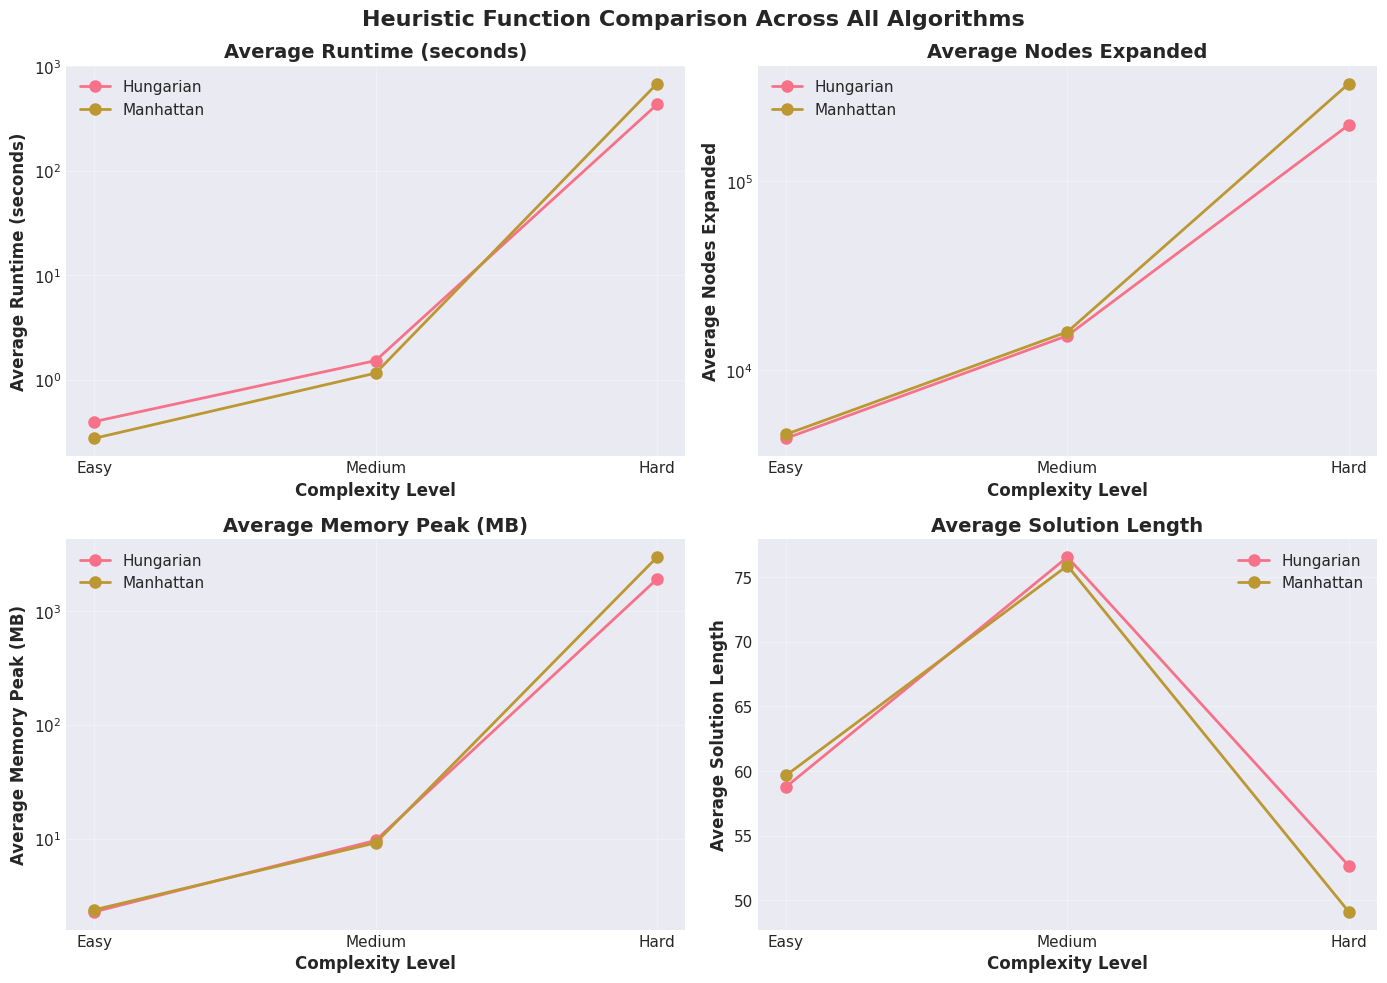

HEURISTIC FUNCTION COMPARISON SUMMARY:

Manhattan Heuristic:
  Complexity:     Easy
  Avg Runtime:         0.28 seconds
  Avg Nodes:          4,585
  Avg Memory:          2.37 MB
  Avg Sol Length:     59.67

Manhattan Heuristic:
  Complexity:     Medium
  Avg Runtime:         1.16 seconds
  Avg Nodes:         16,000
  Avg Memory:          9.21 MB
  Avg Sol Length:     75.89

Manhattan Heuristic:
  Complexity:     Hard
  Avg Runtime:       682.91 seconds
  Avg Nodes:        329,882
  Avg Memory:       3004.25 MB
  Avg Sol Length:     49.11

Hungarian Heuristic:
  Complexity:     Easy
  Avg Runtime:         0.40 seconds
  Avg Nodes:          4,367
  Avg Memory:          2.28 MB
  Avg Sol Length:     58.78

Hungarian Heuristic:
  Complexity:     Medium
  Avg Runtime:         1.53 seconds
  Avg Nodes:         15,271
  Avg Memory:          9.68 MB
  Avg Sol Length:     76.56

Hungarian Heuristic:
  Complexity:     Hard
  Avg Runtime:       431.40 seconds
  Avg Nodes:        199,443
  Avg Me

In [26]:
# 5.1 Heuristic Function Comparison Across All Algorithms Per Complexity Level

# Filter data to only include solved cases for fair comparison
df_solved = df_main[df_main['solved'] == True].copy()

# Create figure with subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Heuristic Function Comparison Across All Algorithms', fontsize=16, fontweight='bold')

# Define metrics to compare
metrics = [
    ('runtime_seconds', 'Average Runtime (seconds)', 'log'),
    ('nodes_expanded', 'Average Nodes Expanded', 'log'), 
    ('memory_peak_mb', 'Average Memory Peak (MB)', 'log'),
    ('solution_length', 'Average Solution Length', 'linear')
]
complexity_order = ['Easy', 'Medium', 'Hard']
df_solved['complexity'] = pd.Categorical(df_solved['complexity'], categories=complexity_order, ordered=True)

# Create comparison for each metric
for idx, (metric, title, scale) in enumerate(metrics):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Group by heuristic and complexity level, calculate mean
    heur_performance = df_solved.groupby(['heuristic_clean', 'complexity'])[metric].mean().reset_index()
    
    # Plot for each heuristic
    for heuristic in heur_performance['heuristic_clean'].unique():
        heur_data = heur_performance[heur_performance['heuristic_clean'] == heuristic]
        ax.plot(heur_data['complexity'], heur_data[metric], 
                marker='o', linewidth=2, markersize=8, label=f'{heuristic}')
    
    ax.set_xlabel('Complexity Level', fontsize=12, fontweight='bold')
    ax.set_ylabel(title, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    if scale == 'log':
        ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("HEURISTIC FUNCTION COMPARISON SUMMARY:")
print("="*50)
for heuristic in df_solved['heuristic_clean'].unique():
    for complexity in complexity_order:
        heur_data = df_solved[
            (df_solved['heuristic_clean'] == heuristic) & 
            (df_solved['complexity'] == complexity)
        ]
        avg_runtime = heur_data['runtime_seconds'].mean()
        avg_nodes = heur_data['nodes_expanded'].mean()
        avg_memory = heur_data['memory_peak_mb'].mean()
        avg_solution = heur_data['solution_length'].mean()
        print(f"\n{heuristic} Heuristic:")
        print(f"  Complexity:     {complexity}")
        print(f"  Avg Runtime:     {avg_runtime:8.2f} seconds")
        print(f"  Avg Nodes:       {avg_nodes:8,.0f}")
        print(f"  Avg Memory:      {avg_memory:8.2f} MB")
        print(f"  Avg Sol Length:  {avg_solution:8.2f}")


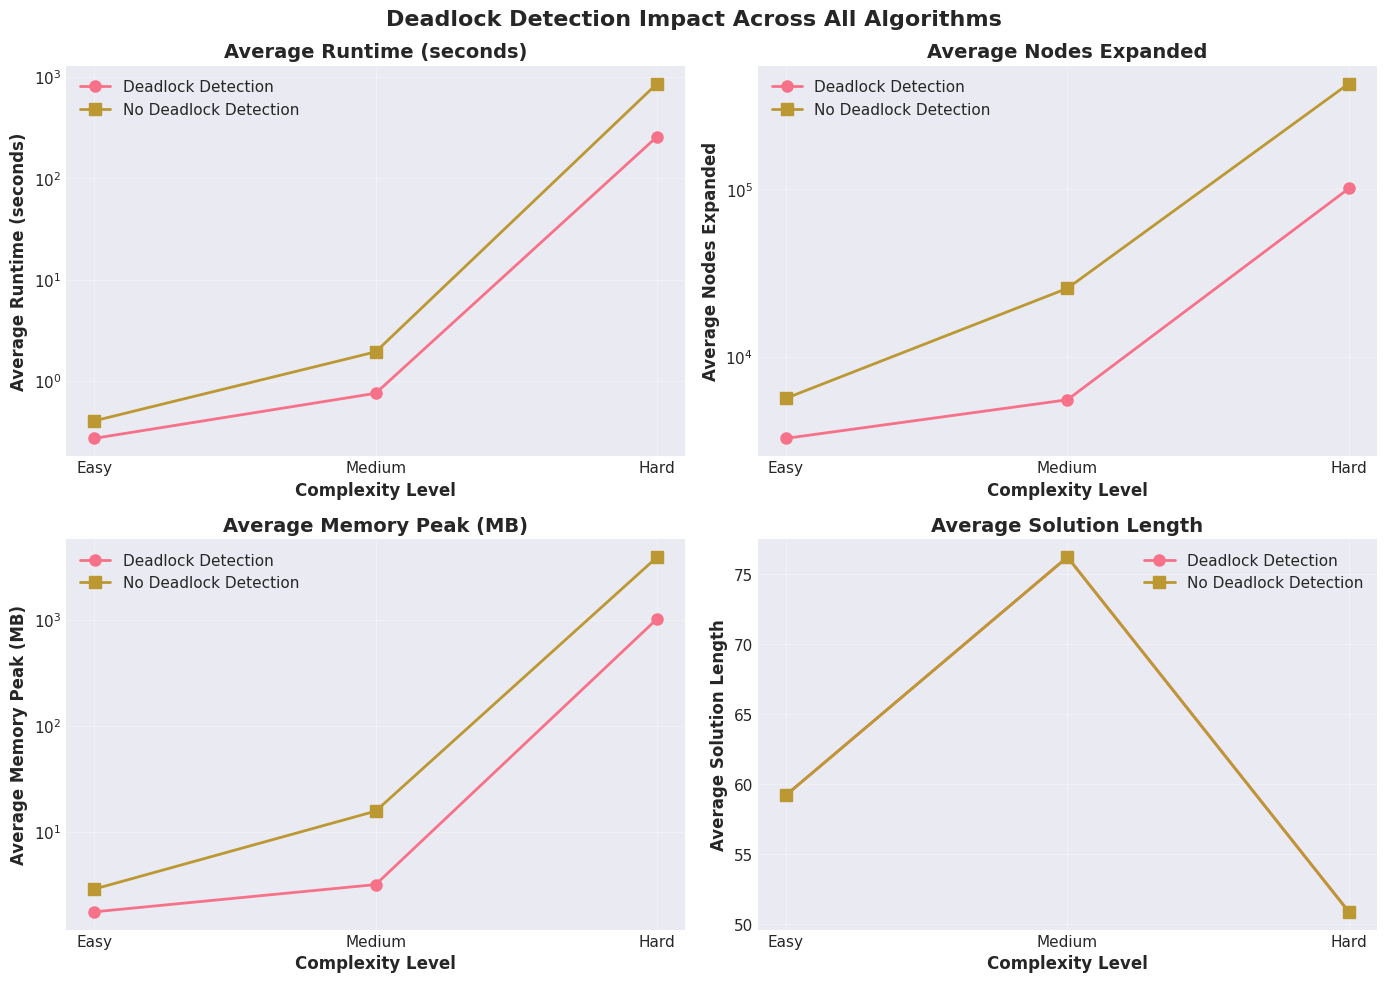

DEADLOCK DETECTION IMPACT SUMMARY:

With Deadlock Detection:
  Avg Runtime:         0.27 seconds
  Avg Nodes:          3,274
  Avg Memory:          1.76 MB
  Avg Sol Length:     59.22

With Deadlock Detection:
  Avg Runtime:         0.76 seconds
  Avg Nodes:          5,562
  Avg Memory:          3.18 MB
  Avg Sol Length:     76.22

With Deadlock Detection:
  Avg Runtime:       257.00 seconds
  Avg Nodes:        101,326
  Avg Memory:       1022.02 MB
  Avg Sol Length:     50.89

Without Deadlock Detection:
  Avg Runtime:         0.40 seconds
  Avg Nodes:          5,678
  Avg Memory:          2.89 MB
  Avg Sol Length:     59.22

Without Deadlock Detection:
  Avg Runtime:         1.94 seconds
  Avg Nodes:         25,710
  Avg Memory:         15.70 MB
  Avg Sol Length:     76.22

Without Deadlock Detection:
  Avg Runtime:       857.31 seconds
  Avg Nodes:        428,000
  Avg Memory:       3909.67 MB
  Avg Sol Length:     50.89

DEADLOCK DETECTION EFFICIENCY GAINS:
  Runtime Improvement:  

In [28]:
# 5.2 Deadlock Detection Impact Across All Algorithms Per Complexity Level

# Create figure with subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Deadlock Detection Impact Across All Algorithms', fontsize=16, fontweight='bold')

# Define metrics to compare
metrics = [
    ('runtime_seconds', 'Average Runtime (seconds)', 'log'),
    ('nodes_expanded', 'Average Nodes Expanded', 'log'), 
    ('memory_peak_mb', 'Average Memory Peak (MB)', 'log'),
    ('solution_length', 'Average Solution Length', 'linear')
]
complexity_order = ['Easy', 'Medium', 'Hard']
df_solved['complexity'] = pd.Categorical(df_solved['complexity'], categories=complexity_order, ordered=True)

# Create comparison for each metric
for idx, (metric, title, scale) in enumerate(metrics):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Group by deadlock detection and complexity level, calculate mean (only solved cases)
    deadlock_performance = df_solved.groupby(['pruning_deadlock', 'complexity'])[metric].mean().reset_index()
    
    # Plot for each deadlock setting
    for pruning in [True, False]:
        deadlock_data = deadlock_performance[deadlock_performance['pruning_deadlock'] == pruning]
        label = 'Deadlock Detection' if pruning else 'No Deadlock Detection'
        marker = 'o' if pruning else 's'
        ax.plot(deadlock_data['complexity'], deadlock_data[metric], 
                marker=marker, linewidth=2, markersize=8, label=label)
    
    ax.set_xlabel('Complexity Level', fontsize=12, fontweight='bold')
    ax.set_ylabel(title, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    if scale == 'log':
        ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("DEADLOCK DETECTION IMPACT SUMMARY:")
print("="*50)
for pruning in [True, False]:
    for complexity in complexity_order:
        deadlock_data = df_solved[
            (df_solved['pruning_deadlock'] == pruning) & 
            (df_solved['complexity'] == complexity)
        ]
        label = 'With Deadlock Detection' if pruning else 'Without Deadlock Detection'
        avg_runtime = deadlock_data['runtime_seconds'].mean()
        avg_nodes = deadlock_data['nodes_expanded'].mean()
        avg_memory = deadlock_data['memory_peak_mb'].mean()
        avg_solution = deadlock_data['solution_length'].mean()
        
        print(f"\n{label}:")
        print(f"  Avg Runtime:     {avg_runtime:8.2f} seconds")
        print(f"  Avg Nodes:       {avg_nodes:8,.0f}")
        print(f"  Avg Memory:      {avg_memory:8.2f} MB")
        print(f"  Avg Sol Length:  {avg_solution:8.2f}")

# Calculate improvement ratios
with_deadlock = df_solved[df_solved['pruning_deadlock'] == True]
without_deadlock = df_solved[df_solved['pruning_deadlock'] == False]

if len(with_deadlock) > 0 and len(without_deadlock) > 0:
    runtime_improvement = without_deadlock['runtime_seconds'].mean() / with_deadlock['runtime_seconds'].mean()
    nodes_improvement = without_deadlock['nodes_expanded'].mean() / with_deadlock['nodes_expanded'].mean()
    memory_improvement = without_deadlock['memory_peak_mb'].mean() / with_deadlock['memory_peak_mb'].mean()
    
    print(f"\nDEADLOCK DETECTION EFFICIENCY GAINS:")
    print(f"  Runtime Improvement:  {runtime_improvement:6.2f}x faster")
    print(f"  Nodes Reduction:      {nodes_improvement:6.2f}x fewer nodes")
    print(f"  Memory Improvement:   {memory_improvement:6.2f}x less memory")


## AWA* Performance Analysis by Weight

In [12]:
# --- Data Cleaning for AWA* Iterations ---
# Create a copy to avoid modifying the original dataframe
df_awa_cleaned = df_awa_iterations.copy()

# Ensure data is sorted correctly for forward-filling
df_awa_cleaned = df_awa_cleaned.sort_values(['level_number', 'heuristic_clean', 'pruning_deadlock', 'iteration_number'])

# Replace solution_length with NaN where the iteration did not find a solution.
df_awa_cleaned['solution_length'] = df_awa_cleaned['solution_length'].where(df_awa_cleaned['solved'], np.nan)

# Forward-fill the null solution lengths within each experiment group.
# This carries forward the last known good solution for subsequent iterations that don't improve.
df_awa_cleaned['solution_length'] = df_awa_cleaned.groupby(
    ['level_number', 'heuristic_clean', 'pruning_deadlock']
)['solution_length'].ffill()

df_awa_cleaned['solution_length'].unique()

array([26., 22., 67., 61., 90., 84., 80., 86., 97., 93., 44., 45., 38.,
       34., 64., 58., 56., 62., 49., 47.])

In [13]:
def plot_awa_iterations(df, var, var_name='Level Number'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))

    # --- Runtime Scaling by Weight ---
    sns.lineplot(
        data=df,
        x=var, 
        y='runtime_seconds', 
        hue='weight',
        marker='o',
        palette='viridis',
        ax=ax1
    )
    ax1.set_title('AWA* Runtime Scaling by Weight', fontsize=14, fontweight='bold')
    ax1.set_xlabel(f'Puzzle {var_name}')
    ax1.set_ylabel('Average Runtime (seconds)')
    ax1.set_yscale('log')
    ax1.legend(title='Weight')

    # --- Solution Length by Weight ---
    # df_solved_awa = df_awa_iterations[df_awa_iterations['solved'] == True]
    sns.lineplot(
        data=df,
        x=var,
        y='solution_length',
        hue='weight',
        marker='o',
        palette='viridis',
        ax=ax2
    )
    ax2.set_title('AWA* Solution Quality by Weight', fontsize=14, fontweight='bold')
    ax2.set_xlabel(f'Puzzle {var_name}')
    ax2.set_ylabel('Average Solution Length')
    ax2.legend(title='Weight')

    # --- Memory Usage by Weight ---
    sns.lineplot(
        data=df,
        x=var,
        y='memory_peak_mb',
        hue='weight',
        marker='o',
        palette='viridis',
        ax=ax3
    )
    ax3.set_title('AWA* Memory Usage by Weight', fontsize=14, fontweight='bold')
    ax3.set_xlabel(f'Puzzle {var_name}')
    ax3.set_ylabel('Average Memory Usage (MB)')
    ax3.legend(title='Weight')

    plt.tight_layout()
    plt.show()



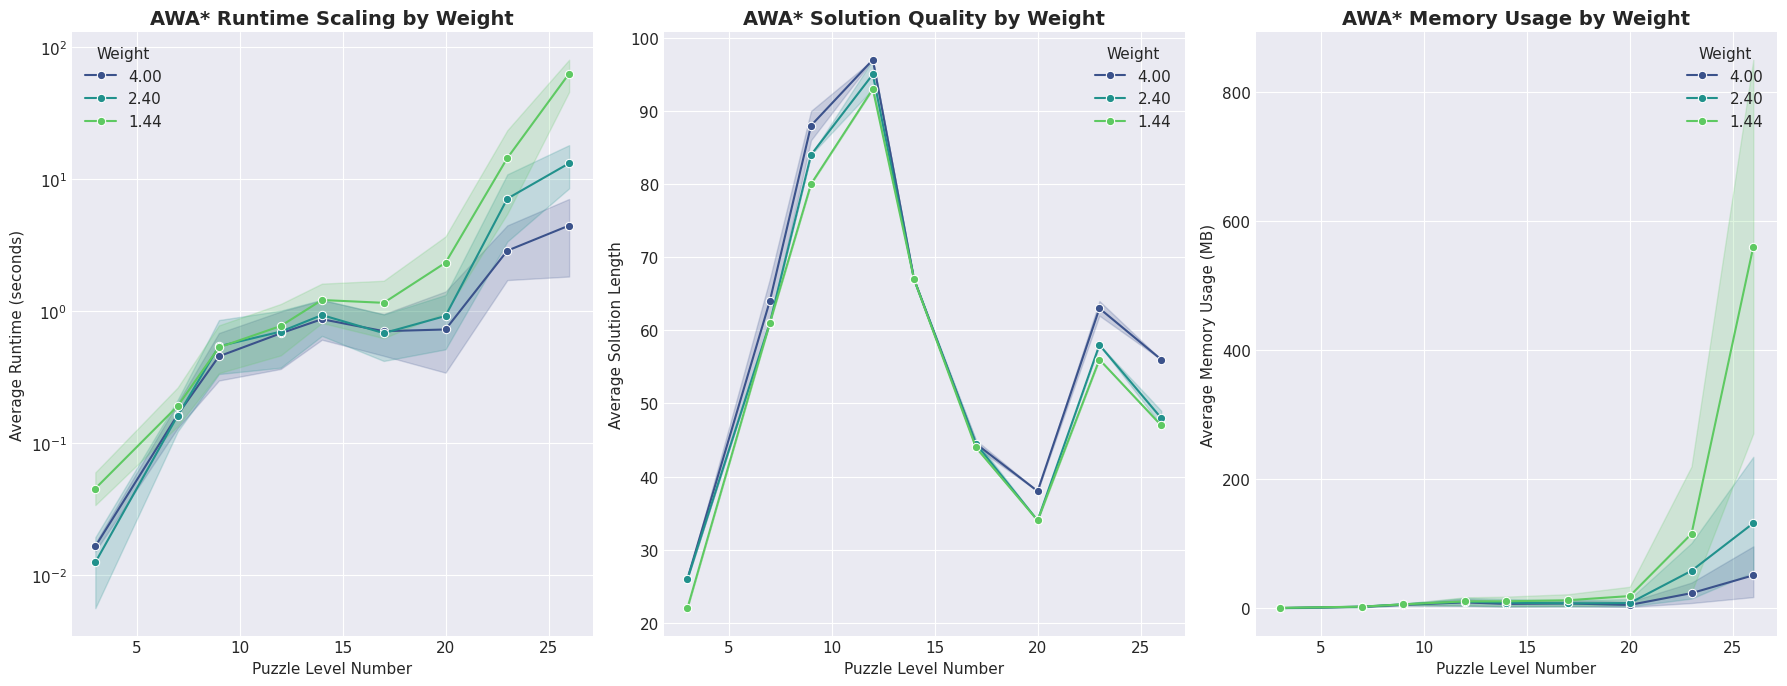

In [14]:
plot_awa_iterations(df_awa_cleaned, 'level_number')

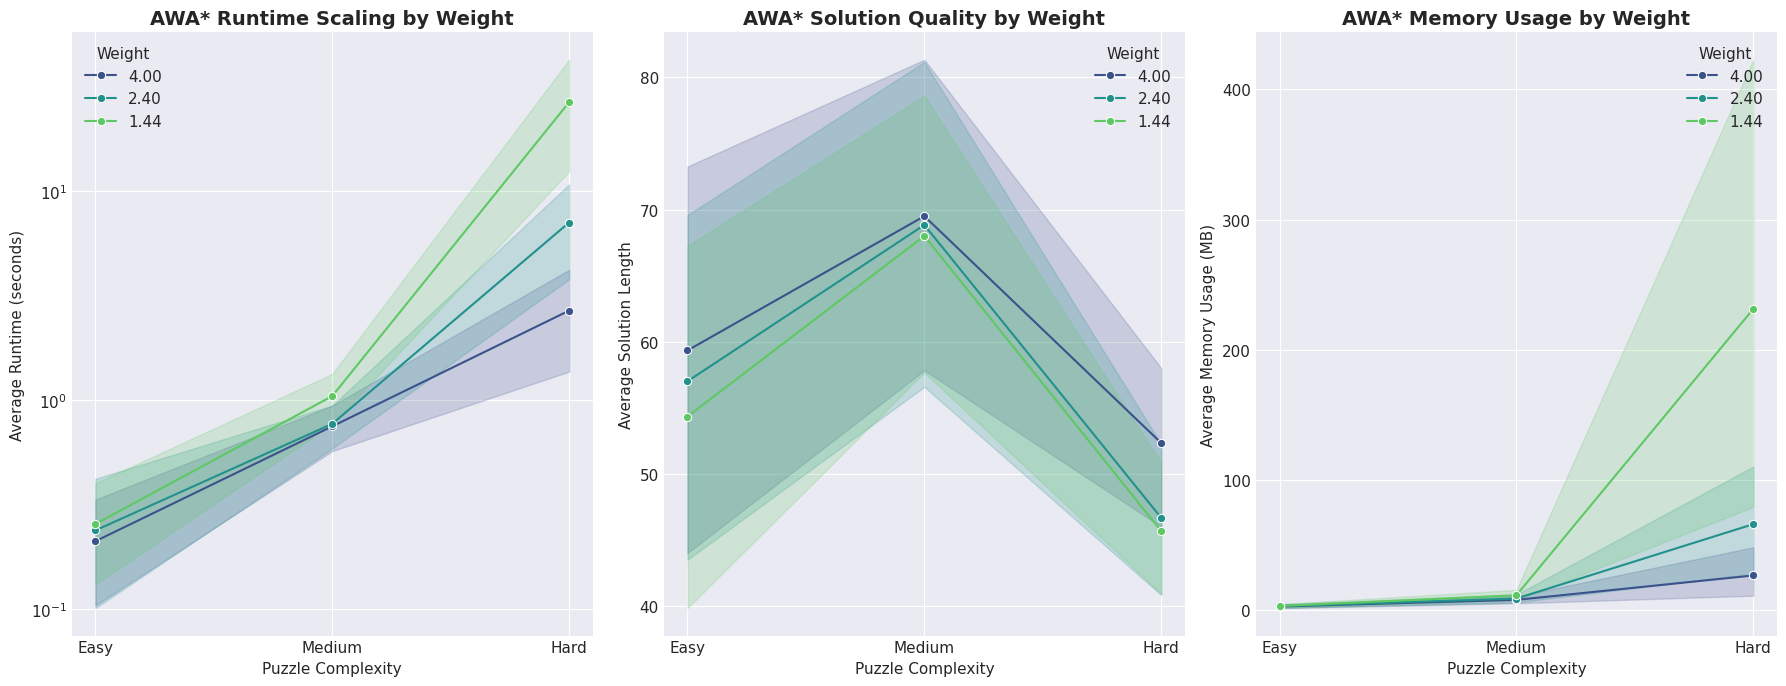

In [15]:
plot_awa_iterations(df_awa_cleaned, 'complexity', 'Complexity')

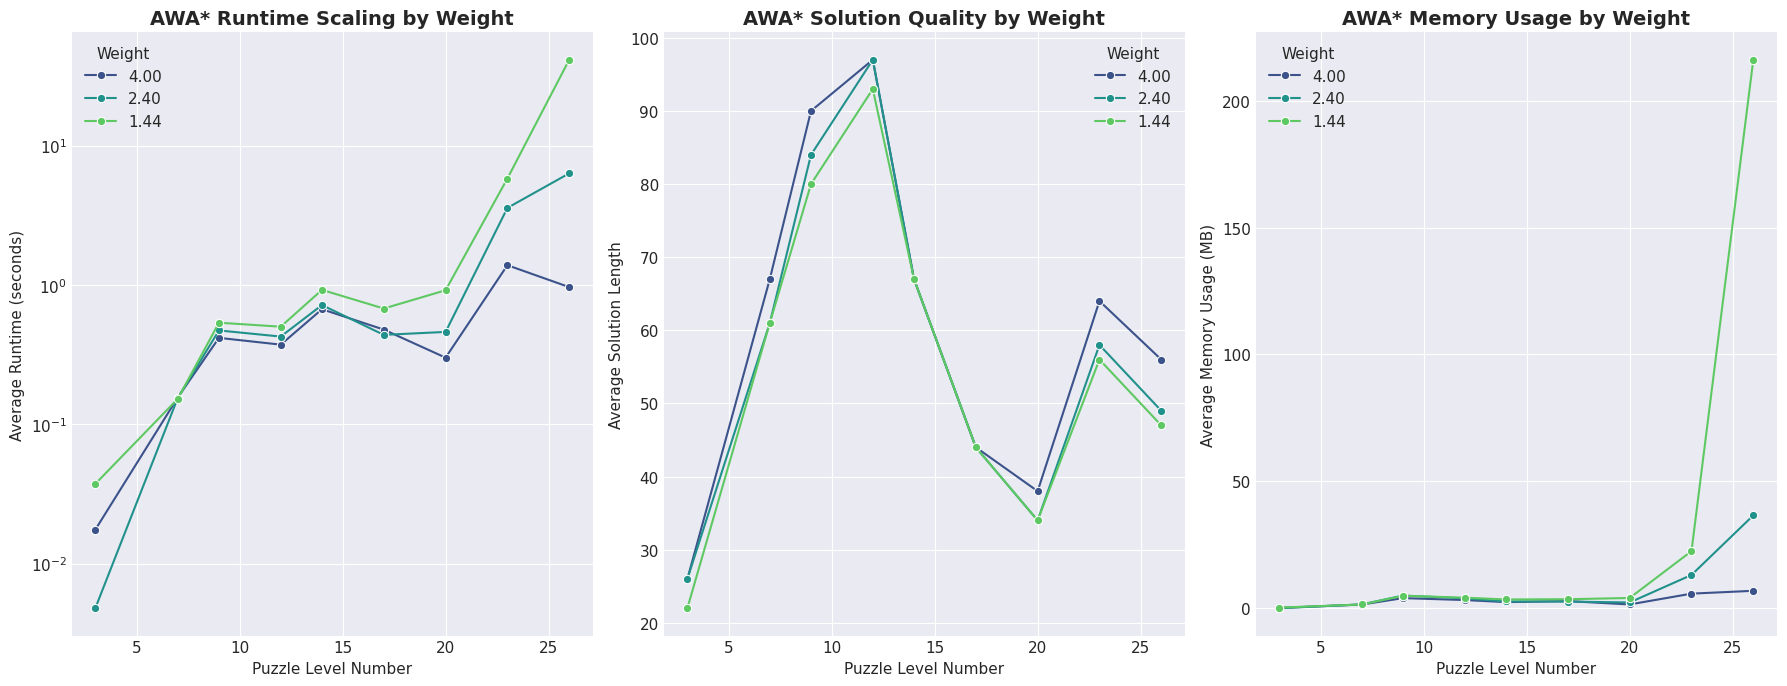

In [16]:
# Plot 1: Trend lines for performance vs. puzzle level, separated by weight
df_awa_iterations_filtered = df_awa_cleaned[(df_awa_cleaned['pruning_deadlock'] == True)
                                            & (df_awa_cleaned['heuristic_clean'] == 'Hungarian')]
plot_awa_iterations(df_awa_iterations_filtered, 'level_number')

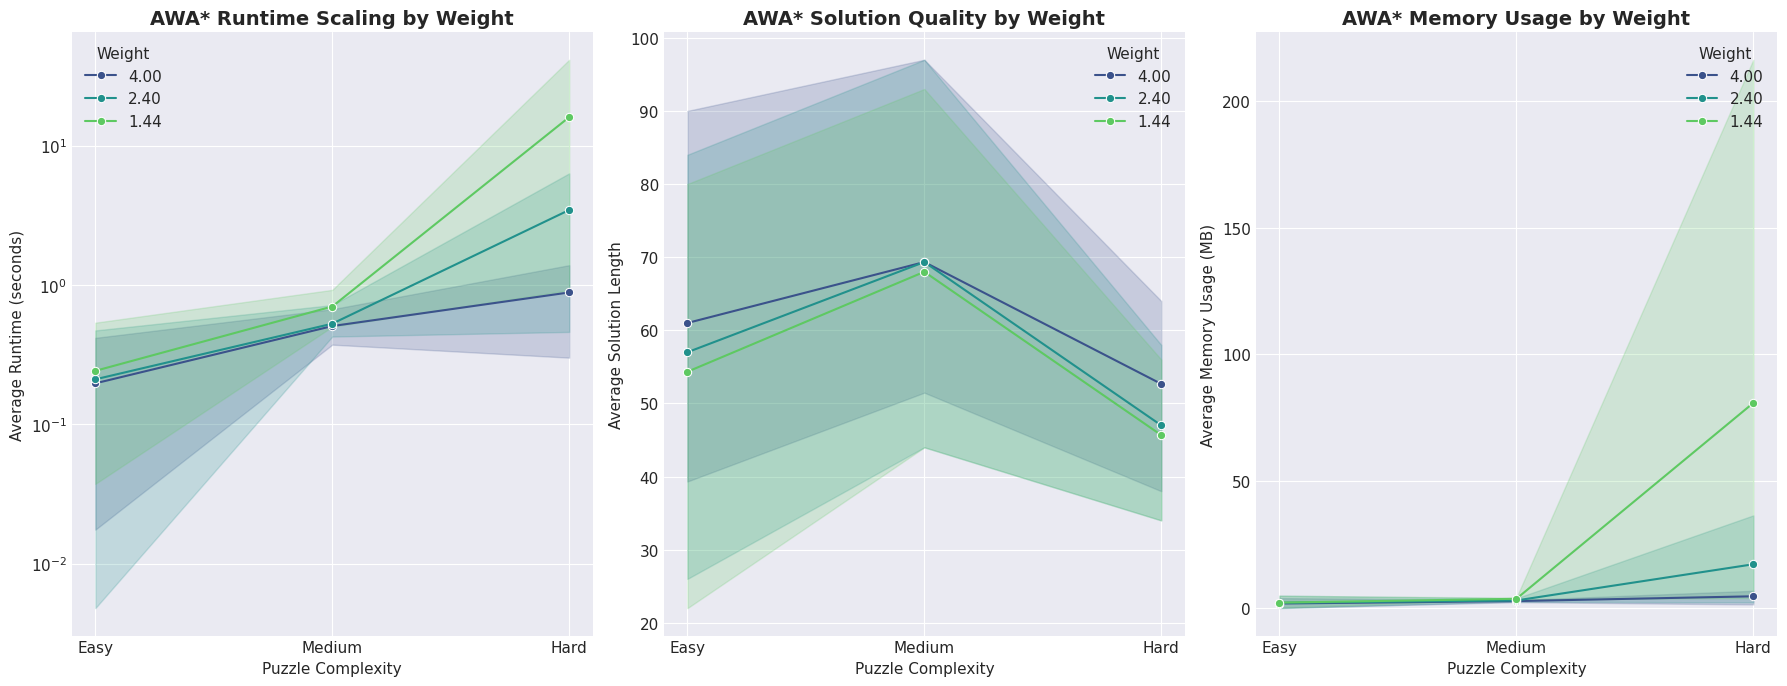

In [17]:
plot_awa_iterations(df_awa_iterations_filtered, 'complexity', 'Complexity')

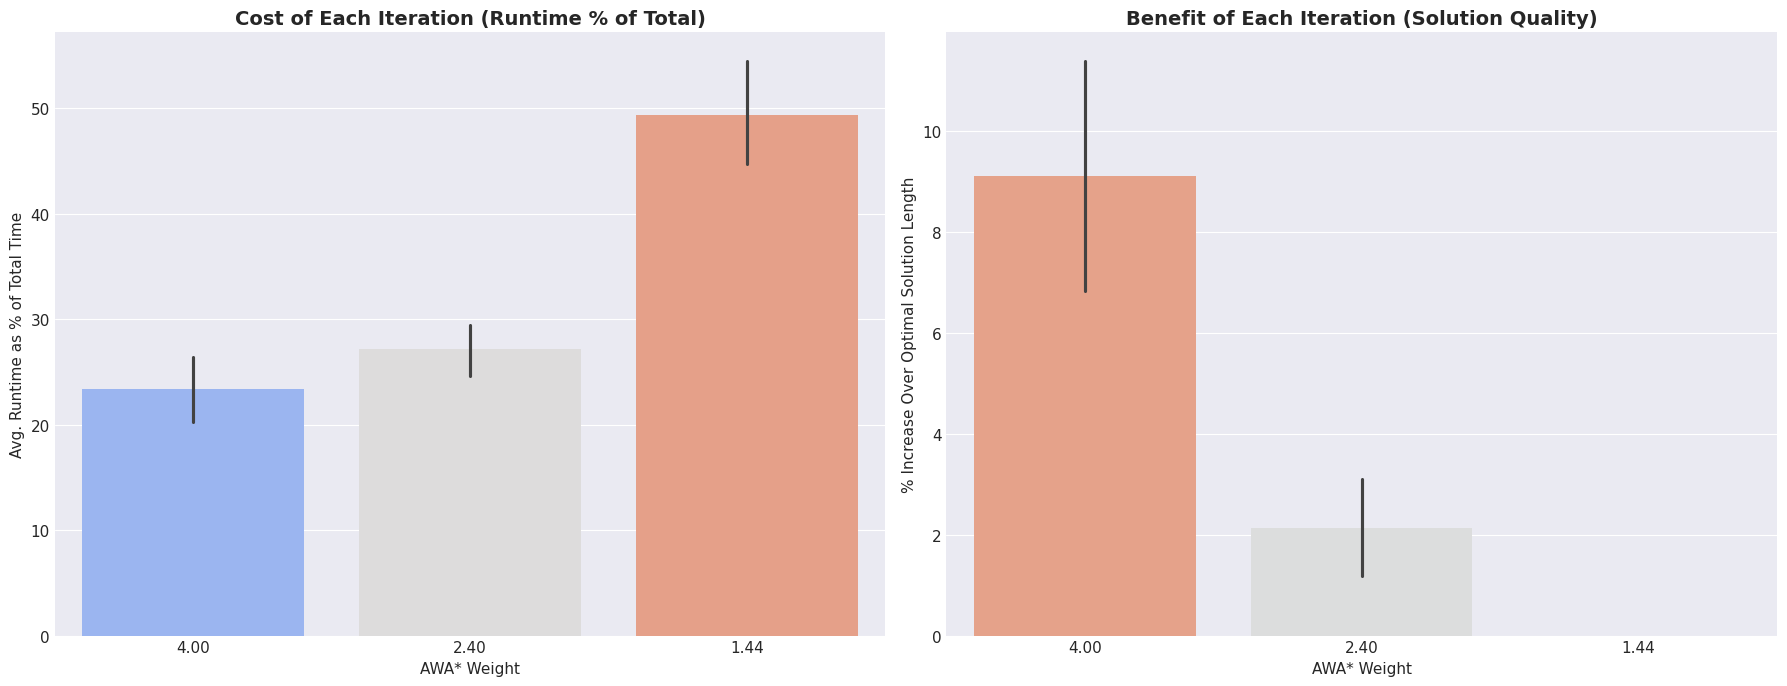

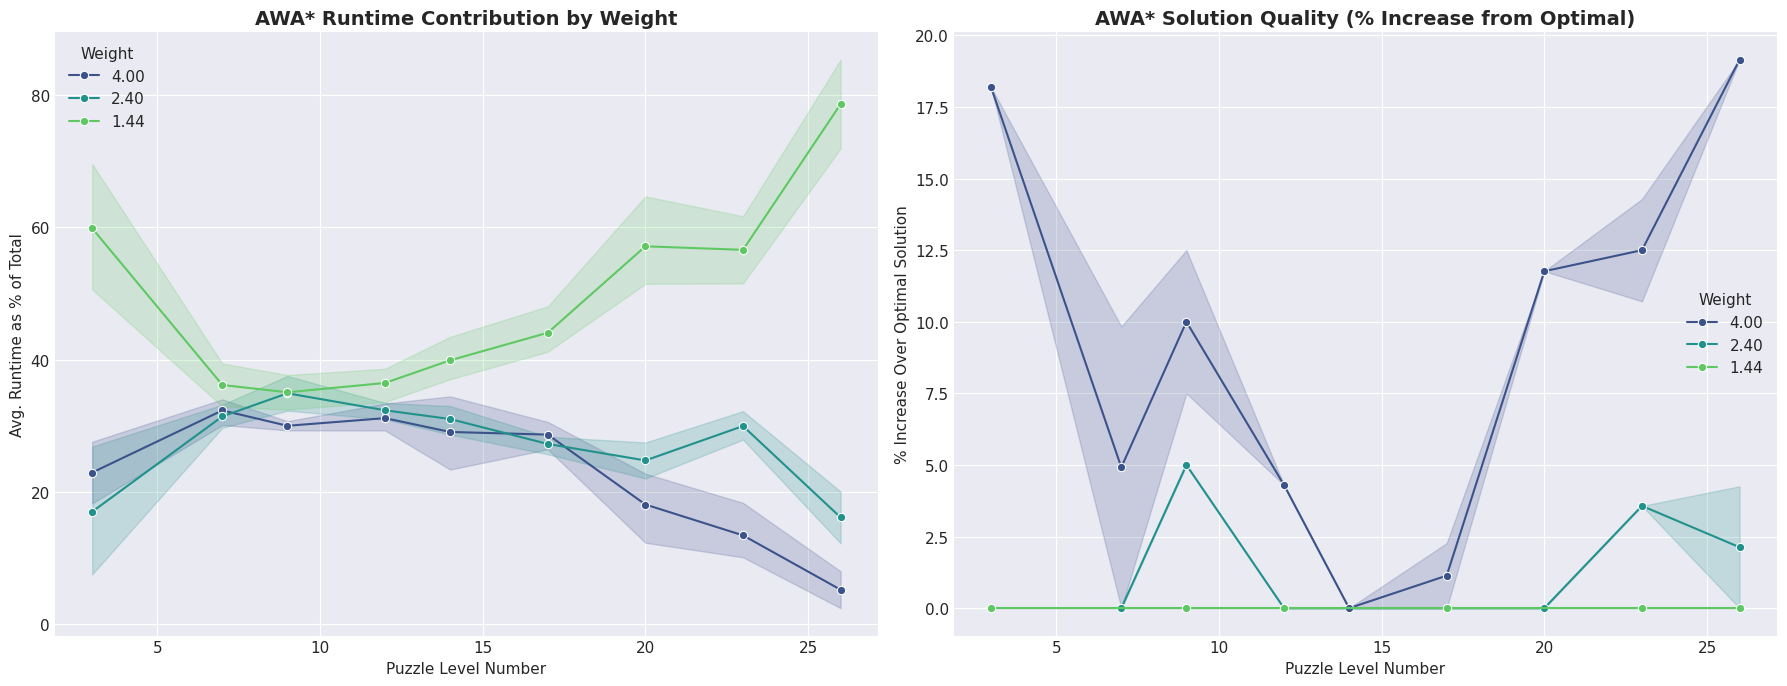

In [18]:
# --- Data Preparation for Percentage-Based Analysis ---

# 1. Correctly determine the final, true optimal solution for each experiment run.
# This fixes the data inconsistency that led to negative percentages.
true_optimal_lengths = df_main[(df_main['algorithm_clean'] == 'A*')&(df_main['solved'])].groupby(
    ['level_number', 'heuristic_clean', 'pruning_deadlock']
)['solution_length'].min().to_frame('optimal_sol_len').reset_index()

# Get total runtime for each run from the main dataframe
total_runtimes = df_main[df_main['algorithm_clean'] == 'AWA*'][[
    'level_number', 'heuristic_clean', 'pruning_deadlock', 'runtime_seconds'
]].rename(columns={'runtime_seconds': 'total_runtime'})

# 2. Merge these correct stats back into the iteration data
awa_perf_analysis_df = pd.merge(
    df_awa_cleaned,
    true_optimal_lengths,
    on=['level_number', 'heuristic_clean', 'pruning_deadlock']
)
awa_perf_analysis_df = pd.merge(
    awa_perf_analysis_df,
    total_runtimes,
    on=['level_number', 'heuristic_clean', 'pruning_deadlock']
)

# 3. Calculate the percentage metrics using the corrected optimal length
awa_perf_analysis_df['runtime_percentage'] = (awa_perf_analysis_df['runtime_seconds'] / awa_perf_analysis_df['total_runtime']) * 100
awa_perf_analysis_df['sol_len_increase_pct'] = (
    (awa_perf_analysis_df['solution_length'] / awa_perf_analysis_df['optimal_sol_len']) - 1
) * 100

# --- Plot Generation ---

# Define the order of weights we want
weight_order = ['4.00', '2.40', '1.44']

# Plot 2: Bar Plots for Percentage Breakdown
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# First plot with ordered weights
sns.barplot(
    data=awa_perf_analysis_df, x='weight', y='runtime_percentage',
    order=weight_order,
    palette='coolwarm', ax=ax1
)
ax1.set_title('Cost of Each Iteration (Runtime % of Total)', fontsize=14, fontweight='bold')
ax1.set_xlabel('AWA* Weight')
ax1.set_ylabel('Avg. Runtime as % of Total Time')

# Second plot with the same weight order
sns.barplot(
    data=awa_perf_analysis_df[awa_perf_analysis_df['solved'] == True], x='weight', y='sol_len_increase_pct',
    order=weight_order,
    palette='coolwarm_r', ax=ax2
)
ax2.set_title('Benefit of Each Iteration (Solution Quality)', fontsize=14, fontweight='bold')
ax2.set_xlabel('AWA* Weight')
ax2.set_ylabel('% Increase Over Optimal Solution Length')

plt.tight_layout()
plt.show()


# Plot 3: Trend Lines for Percentage-Based Metrics
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(18, 7))

# First trend plot with ordered weights in legend
sns.lineplot(
    data=awa_perf_analysis_df, x='level_number', y='runtime_percentage', 
    hue='weight', hue_order=weight_order,
    marker='o', palette='viridis', ax=ax3
)
ax3.set_title('AWA* Runtime Contribution by Weight', fontsize=14, fontweight='bold')
ax3.set_xlabel('Puzzle Level Number')
ax3.set_ylabel('Avg. Runtime as % of Total')
ax3.legend(title='Weight')

# Second trend plot with the same weight order in legend
sns.lineplot(
    data=awa_perf_analysis_df[awa_perf_analysis_df['solved'] == True], x='level_number', y='sol_len_increase_pct', 
    hue='weight', hue_order=weight_order,
    marker='o', palette='viridis', ax=ax4
)
ax4.set_title('AWA* Solution Quality (% Increase from Optimal)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Puzzle Level Number')
ax4.set_ylabel('% Increase Over Optimal Solution')
ax4.legend(title='Weight')

plt.tight_layout()
plt.show()